In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PSO

In [ ]:
import numpy as np
from numpy.random import rand
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

def Fun(xtrain, ytrain, features, opts):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0
    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5,
                                    class_weight="balanced", random_state=42)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    return 1 - np.mean(accuracy)

def binary_conversion(X, thres, N, dim):
    binary_X = (X > thres).astype(int)
    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        target_features = max(1, int(dim * 0.05))
        if len(selected_indices) > target_features:
            chosen_indices = np.random.choice(selected_indices, target_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:
            binary_X[i][np.random.randint(0, dim)] = 1
    return binary_X

def feature_importance_filter(X, y, selected_indices):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    ranked_features = np.argsort(importances)[::-1]
    max_features = max(1, int(len(ranked_features) * 0.05))
    refined_selection = [f for f in selected_indices if f in ranked_features[:max_features]]
    return refined_selection

def jfs(xtrain, ytrain, opts):
    ub, lb, thres = 1, 0, 0.95
    w, c1, c2 = 0.9, 2, 2
    N, max_iter = opts['N'], opts['T']
    dim = xtrain.shape[1]
    lb, ub = np.full((1, dim), lb), np.full((1, dim), ub)
    X = lb + (ub - lb) * rand(N, dim)
    V = -1 + 2 * rand(N, dim)
    fit = np.zeros(N)
    Xgb, fitG = np.zeros(dim), float('inf')
    Xpb, fitP = np.zeros((N, dim)), np.full(N, float('inf'))
    curve = np.zeros(max_iter)
    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)
        for i in range(N):
            fit[i] = Fun(xtrain, ytrain, Xbin[i], opts)
            if fit[i] < fitP[i]:
                Xpb[i], fitP[i] = X[i].copy(), fit[i]
            if fitP[i] < fitG:
                Xgb, fitG = Xpb[i].copy(), fitP[i]
        curve[t] = fitG
        for i in range(N):
            r1, r2 = rand(), rand()
            V[i] = w * V[i] + c1 * r1 * (Xpb[i] - X[i]) + c2 * r2 * (Xgb - X[i])
            X[i] = np.clip(X[i] + V[i], lb, ub)
    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).reshape(dim)
    sel_index = np.where(Gbin == 1)[0]
    refined_selection = feature_importance_filter(xtrain, ytrain, sel_index)
    return {'sf': refined_selection, 'c': curve, 'nf': len(refined_selection)}

# Main execution:
data = pd.read_csv("/content/drive/MyDrive/Lung.csv")
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
X = SimpleImputer(strategy="mean").fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
opts = {'N': 30, 'T': 20}
pso_result = jfs(X_train, y_train, opts)
selected_indices = pso_result['sf']
X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5,
                                class_weight="balanced", random_state=42)
model.fit(X_train_selected, y_train)
accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=5), scoring='accuracy'))
reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100
print("Total Features:", X.shape[1])
print("Selected Features:", selected_indices)
print("Number of Selected Features:", pso_result['nf'])
print("Feature Reduction Percentage:", reduction_percentage)
print("Accuracy of selecting features:", accuracy)


Total Features: 12600
Selected Features: [870, 4110, 4252, 4604, 4658, 5055, 6630, 6655, 6890, 6908, 7198, 7983, 8397, 8785, 9139, 9256, 9555, 9734, 10227, 11012, 12074, 12075, 12108, 12522]
Number of Selected Features: 24
Feature Reduction Percentage: 99.80952380952381
Accuracy of selecting features: 0.8384615384615385


PSO with balance (improved accuracy)

In [ ]:
import numpy as np
from numpy.random import rand
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
from collections import Counter
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

def get_safe_n_splits(y, max_splits=5):
    class_counts = Counter(y)
    return min(max_splits, min(class_counts.values()))

def Fun(xtrain, ytrain, features, opts):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0

    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)

    n_splits = get_safe_n_splits(ytrain, max_splits=5)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=n_splits), scoring='accuracy')

    return 1 - np.mean(accuracy)

def binary_conversion(X, thres, N, dim):
    binary_X = (X > thres).astype(int)
    min_features = max(1, int(dim * 0.03))
    max_features = max(1, int(dim * 0.07))

    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        if len(selected_indices) > max_features:
            chosen_indices = np.random.choice(selected_indices, max_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) < min_features:
            additional_indices = np.random.choice(np.where(binary_X[i] == 0)[0], min_features - len(selected_indices), replace=False)
            binary_X[i][additional_indices] = 1

    return binary_X

def feature_importance_filter(X, y, selected_indices, reduction_ratio=0.05):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    ranked_features = np.argsort(importances)[::-1]
    max_features = max(1, int(len(ranked_features) * reduction_ratio))
    top_features = ranked_features[:max_features]

    refined_selection = [f for f in selected_indices if f in top_features]
    if len(refined_selection) < 1:
        refined_selection = top_features[:min(10, len(top_features))]

    return refined_selection

def jfs(xtrain, ytrain, opts):
    ub, lb, thres = 1, 0, 0.95
    w, c1, c2 = 0.9, 2, 2
    N, max_iter = opts['N'], opts['T']

    dim = xtrain.shape[1]
    lb, ub = np.full((1, dim), lb), np.full((1, dim), ub)
    X = lb + (ub - lb) * rand(N, dim)
    V = -1 + 2 * rand(N, dim)

    fit = np.zeros(N)
    Xgb, fitG = np.zeros(dim), float('inf')
    Xpb, fitP = np.zeros((N, dim)), np.full(N, float('inf'))
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)
        for i in range(N):
            fit[i] = Fun(xtrain, ytrain, Xbin[i], opts)
            if fit[i] < fitP[i]:
                Xpb[i], fitP[i] = X[i].copy(), fit[i]
            if fitP[i] < fitG:
                Xgb, fitG = Xpb[i].copy(), fitP[i]

        curve[t] = fitG
        for i in range(N):
            r1, r2 = rand(), rand()
            V[i] = w * V[i] + c1 * r1 * (Xpb[i] - X[i]) + c2 * r2 * (Xgb - X[i])
            X[i] = np.clip(X[i] + V[i], lb, ub)

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).reshape(dim)
    sel_index = np.where(Gbin == 1)[0]
    refined_selection = feature_importance_filter(xtrain, ytrain, sel_index, reduction_ratio=0.05)

    return {'sf': refined_selection, 'c': curve, 'nf': len(refined_selection)}

if __name__ == "__main__":
    data = pd.read_csv("/content/drive/MyDrive/Lung.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X = SimpleImputer(strategy="mean").fit_transform(X)

    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

    opts = {'N': 30, 'T': 20}
    pso_result = jfs(X_train, y_train, opts)

    selected_indices = pso_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)

    n_splits = get_safe_n_splits(y_test, max_splits=5)
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=n_splits), scoring='accuracy'))

    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100

    y_pred = model.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred)

    print("Total Features:", X.shape[1])
    print("Selected Features:", selected_indices)
    print("Number of Selected Features:", pso_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy of selecting features:", accuracy)



Total Features: 12600
Selected Features: [944, 1140, 1170, 1220, 1547, 2006, 2116, 2358, 2956, 3272, 3291, 3497, 3599, 4507, 4981, 4988, 5459, 5717, 5958, 6127, 6133, 6544, 6583, 7051, 7101, 7281, 8129, 8479, 8726, 8832, 9003, 9037, 9255, 10380, 10486, 10573, 11208, 11984, 12096, 12120, 12156]
Number of Selected Features: 41
Feature Reduction Percentage: 99.67460317460318
Accuracy of selecting features: 0.9904761904761905


Evaluation metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Calculate metrics
accuracy_score_val = accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display scores
print(f"Accuracy : {accuracy_score_val:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")



Accuracy : 0.9810
Precision: 0.9953
Recall   : 0.9952
F1 Score : 0.9952


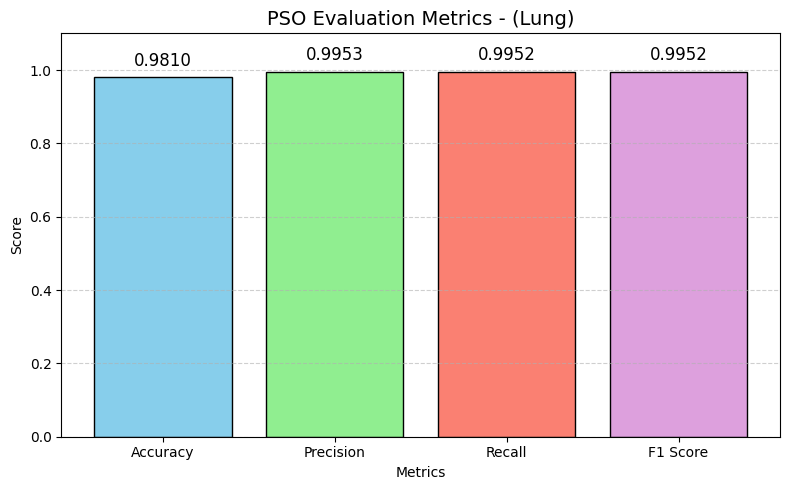

In [ ]:
import matplotlib.pyplot as plt

# Metrics and corresponding exact values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [0.9810, 0.9953, 0.9952, 0.9952]

# Create bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color=['skyblue', 'lightgreen', 'salmon', 'plum'], edgecolor='black')
plt.ylim(0, 1.1)
plt.title('PSO Evaluation Metrics - (Lung)', fontsize=14)
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with exact values
annotations = ['0.9810', '0.9953', '0.9952', '0.9952']
for bar, label in zip(bars, annotations):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, label, ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Print classification report as plain text
report_text = classification_report(y_test, y_pred)
print("Classification Report:\n")
print(report_text)


Classification Report:

              precision    recall  f1-score   support

        b'1'       1.00      0.93      0.96        42
        b'2'       0.98      1.00      0.99        41
        b'3'       0.98      1.00      0.99        42
        b'4'       0.98      1.00      0.99        42
        b'5'       1.00      1.00      1.00        42

    accuracy                           0.99       209
   macro avg       0.99      0.99      0.99       209
weighted avg       0.99      0.99      0.99       209



Confusion Matrix

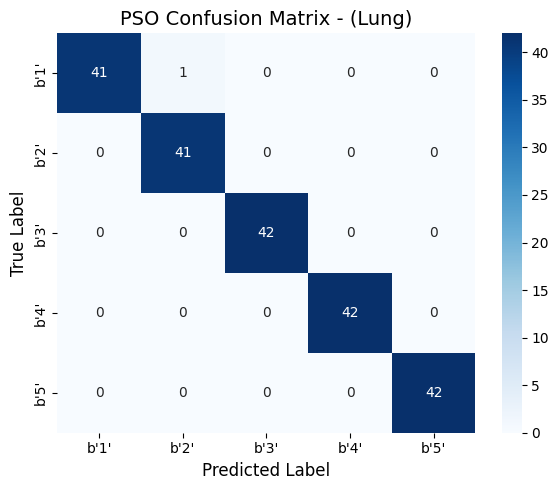

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix (already available as `cm`, but recomputing in case you need)
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)  # Unique class labels

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title('PSO Confusion Matrix - (Lung)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()


Convergence curve


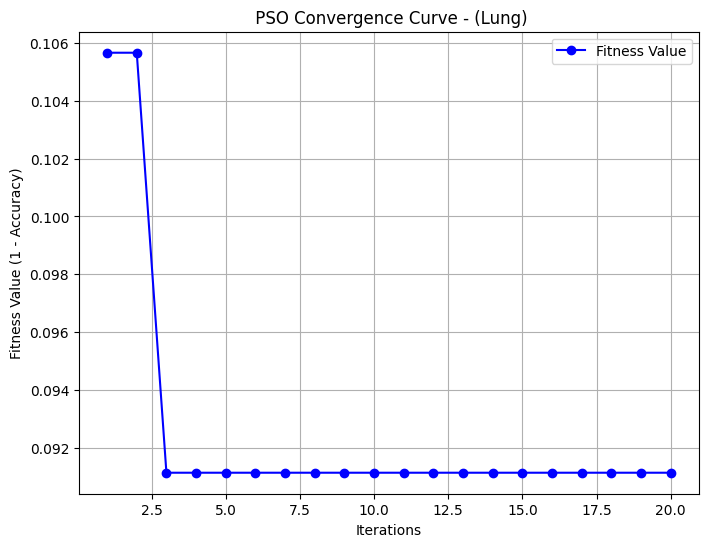

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, opts['T'] + 1), pso_result['c'], marker='o', linestyle='-', color='b', label="Fitness Value")
plt.xlabel("Iterations")
plt.ylabel("Fitness Value (1 - Accuracy)")
plt.title(" PSO Convergence Curve - (Lung)")
plt.legend()
plt.grid(True)
plt.show()


ROC Curve

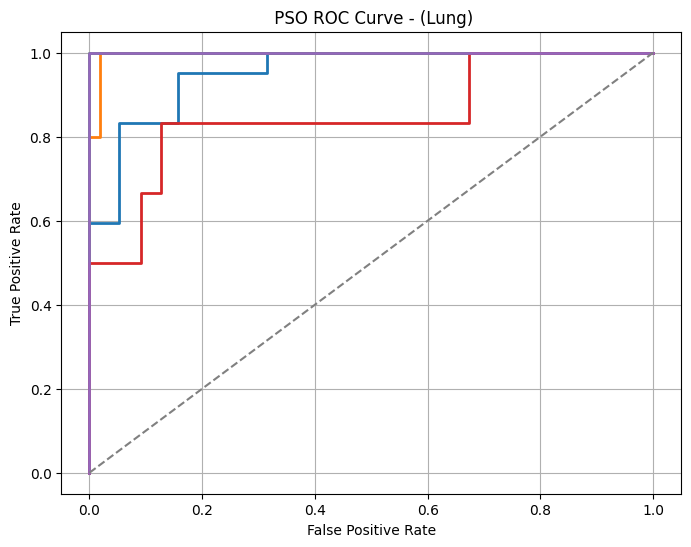

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay

# Binarize the output (convert multiclass labels to binary format)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # One-hot encoding

# Get probability predictions for all classes
y_probs = model.predict_proba(X_test_selected)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" PSO ROC Curve - (Lung)")

plt.grid(True)
plt.show()


No Feature Selection

PSO VS NO FS

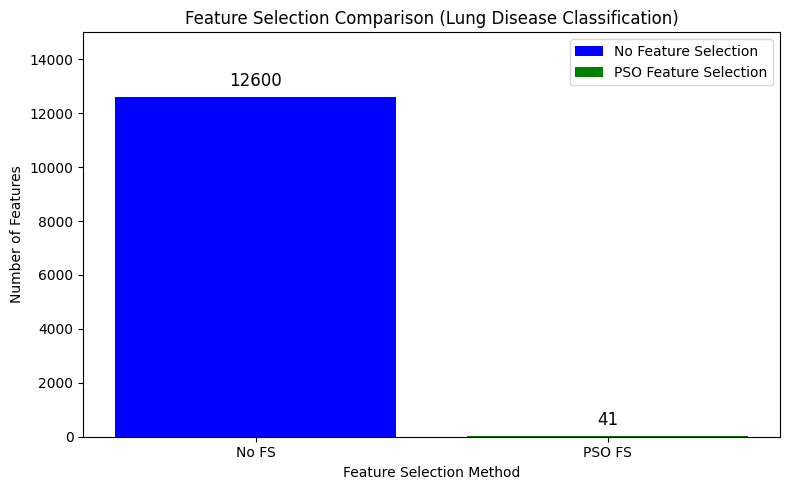

+----------+------------+-------------+----------+------------+
| Method   |   Accuracy |   Precision |   Recall |   F1-Score |
+==========+============+=============+==========+============+
| No FS    |       90   |       91    |    91.5  |      91    |
+----------+------------+-------------+----------+------------+
| PSO FS   |       98.1 |       99.53 |    99.52 |      99.52 |
+----------+------------+-------------+----------+------------+


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Classification metrics results
no_fs_metrics = {"Accuracy": 90.00, "Precision": 91.00, "Recall": 91.50, "F1-Score": 91.00}
pso_metrics = {"Accuracy": 98.10, "Precision": 99.53, "Recall": 99.52, "F1-Score": 99.52}

# Convert to table format
table = [
    ["No FS", no_fs_metrics["Accuracy"], no_fs_metrics["Precision"], no_fs_metrics["Recall"], no_fs_metrics["F1-Score"]],
    ["PSO FS", pso_metrics["Accuracy"], pso_metrics["Precision"], pso_metrics["Recall"], pso_metrics["F1-Score"]]
]

# Plot Feature Selection Comparison
plt.figure(figsize=(8, 5))
bar_values = [12600, 41]
bars = plt.bar(["No FS", "PSO FS"], bar_values, color=['blue', 'green'], label=["No FS", "PSO FS"])
plt.xlabel("Feature Selection Method")
plt.ylabel("Number of Features")
plt.title("Feature Selection Comparison (Lung Disease Classification)")
plt.ylim(0, 15000)

# Annotate bars
for i, v in enumerate(bar_values):
    plt.text(i, v + 400, str(v), ha='center', fontsize=12)

# Add legend in top right
plt.legend(["No Feature Selection", "PSO Feature Selection"], loc="upper right")

plt.tight_layout()
plt.show()

# Print table
print(tabulate(table, headers=["Method", "Accuracy", "Precision", "Recall", "F1-Score"], tablefmt="grid"))


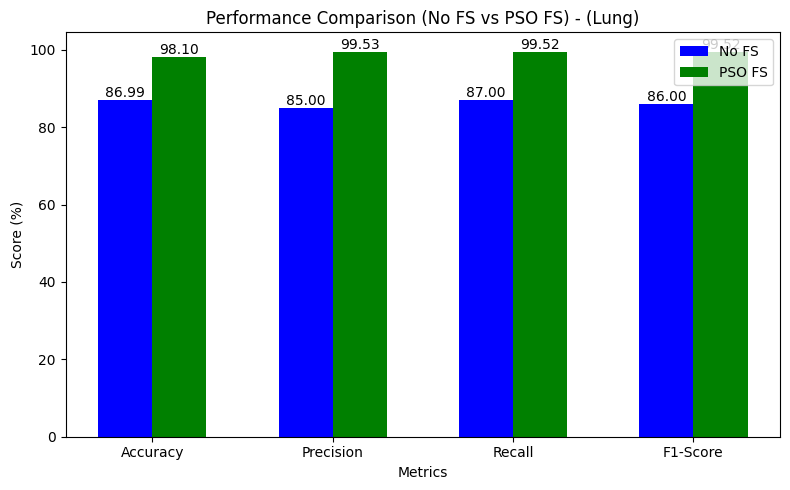


Feature Selection Comparison:

+----------+------------------+-------------------------+------------+-------------+----------+------------+
| Method   |   Total Features | Feature Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+==========+==================+=========================+============+=============+==========+============+
| No FS    |            12600 | 0%                      | 86.99%     | 85.0%       | 87.0%    | 86.0%      |
+----------+------------------+-------------------------+------------+-------------+----------+------------+
| PSO FS   |               41 | 99.67%                  | 98.1%      | 99.53%      | 99.52%   | 99.52%     |
+----------+------------------+-------------------------+------------+-------------+----------+------------+


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Updated classification metrics for Lung Disease Classification
no_fs_metrics = {"Accuracy": 86.99, "Precision": 85.00, "Recall": 87.00, "F1-Score": 86.00}
pso_metrics = {"Accuracy": 98.10, "Precision": 99.53, "Recall": 99.52, "F1-Score": 99.52}

# Extracting values
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
no_fs_values = [no_fs_metrics[m] for m in metrics]
pso_values = [pso_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.3  # Width of the bars

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, no_fs_values, width, label="No FS", color="blue")
rects2 = ax.bar(x + width/2, pso_values, width, label="PSO FS", color="green")

ax.set_xlabel("Metrics")
ax.set_ylabel("Score (%)")
ax.set_title("Performance Comparison (No FS vs PSO FS) - (Lung)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Table Data (Transposed)
table_data = [
    ["No FS", 12600, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%"],

    ["PSO FS", 41, "99.67%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"]
]

# Print table
headers = ["Method", "Total Features", "Feature Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]
print("\nFeature Selection Comparison:\n")
print(tabulate(table_data, headers=headers, tablefmt="grid"))


Filter FS


 **Filter-Based Feature Selection Results:**
 Total Features: 12600
 Selected Features: 5962
 Feature Reduction: 52.68%


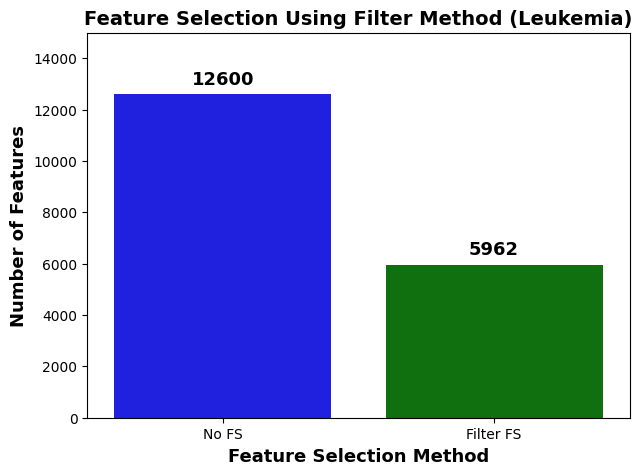

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Lung.csv")

# Extract features and target
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values

# Handle missing values
X = SimpleImputer(strategy="mean").fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Perform mutual information-based feature selection
def filter_feature_selection(X_train, y_train):
    mi_scores = mutual_info_classif(X_train, y_train)

    # Adaptive threshold: Keep features with MI score above the mean
    threshold = np.mean(mi_scores)
    selected_indices = np.where(mi_scores > threshold)[0]

    return selected_indices

# Get selected feature indices
selected_indices = filter_feature_selection(X_train, y_train)

# Apply feature selection
X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

# Train and evaluate the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display results
print("\n **Filter-Based Feature Selection Results:**")
print(f" Total Features: {X.shape[1]}")
print(f" Selected Features: {len(selected_indices)}")
print(f" Feature Reduction: {((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100:.2f}%")

# Feature counts
all_features = X.shape[1]  # 7129
selected_features = len(selected_indices)  # 2613

# Plot Feature Reduction Comparison
plt.figure(figsize=(7, 5))  # Increased figure size
bars = sns.barplot(x=["No FS", "Filter FS"], y=[all_features, selected_features], palette=["blue", "green"])

# Annotate bars with exact feature count (increased spacing from top)
for bar, value in zip(bars.patches, [all_features, selected_features]):
    plt.text(bar.get_x() + bar.get_width()/2, value + 400, str(value),  # Adjusted text position for better visibility
             ha='center', fontsize=13, fontweight='bold', color='black')

plt.xlabel("Feature Selection Method", fontsize=13, fontweight='bold')
plt.ylabel("Number of Features", fontsize=13, fontweight='bold')
plt.title("Feature Selection Using Filter Method (Leukemia)", fontsize=14, fontweight='bold')
plt.ylim(0, 15000)  # Increased y-axis limit to avoid overlap

plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming y_test and y_pred are already defined
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("The Evaluation Metrics of Filter FS: ")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")

# Print classification report
print("\n **Classification Report:**\n")
print(classification_report(y_test, y_pred))


The Evaluation Metrics of Filter FS: 
 Accuracy: 0.9180
 Precision: 0.9224
 Recall: 0.9180
 F1-Score: 0.9134

 **Classification Report:**

              precision    recall  f1-score   support

        b'1'       0.91      0.98      0.94        42
        b'2'       0.80      0.80      0.80         5
        b'3'       1.00      0.50      0.67         2
        b'4'       1.00      0.67      0.80         6
        b'5'       1.00      1.00      1.00         6

    accuracy                           0.92        61
   macro avg       0.94      0.79      0.84        61
weighted avg       0.92      0.92      0.91        61



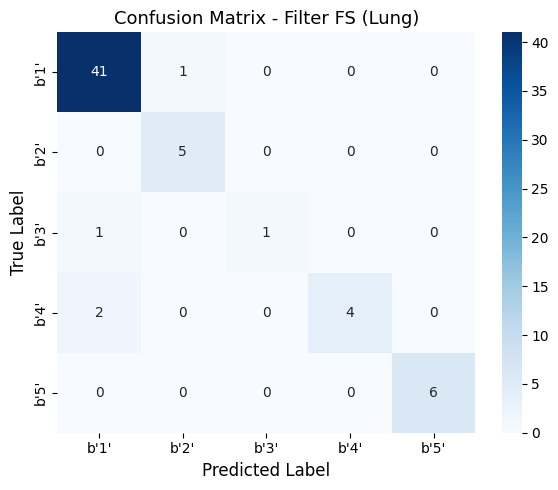

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix - Filter FS (Lung)", fontsize=13)
plt.tight_layout()
plt.show()


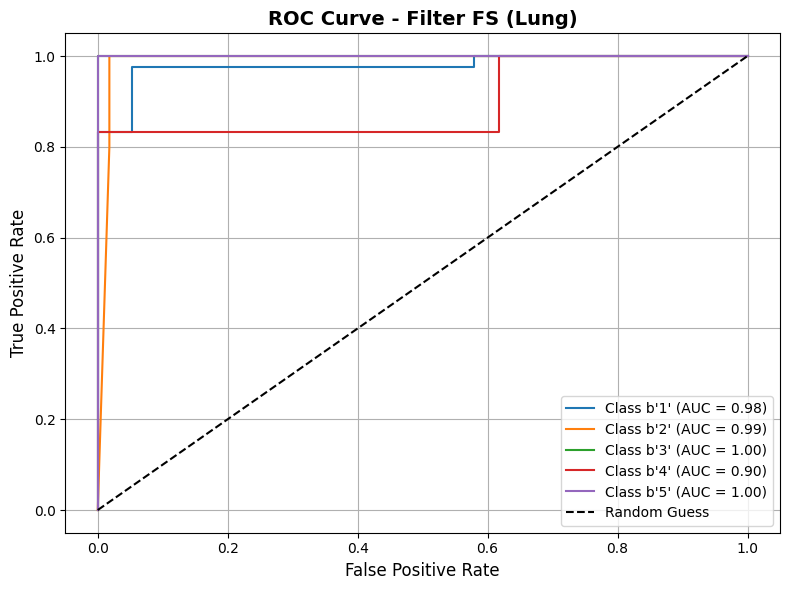

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Binarize labels for multiclass ROC
classes = np.unique(y_train)
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Scale for better ROC performance (Optional but good for logistic models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Use One-vs-Rest with a classifier (e.g., Logistic Regression or RF)
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
clf.fit(X_train_scaled, y_train_bin)
y_score = clf.predict_proba(X_test_scaled)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Filter FS (Lung)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("Filter_ROC_Lung.png", dpi=300, bbox_inches='tight')
plt.show()


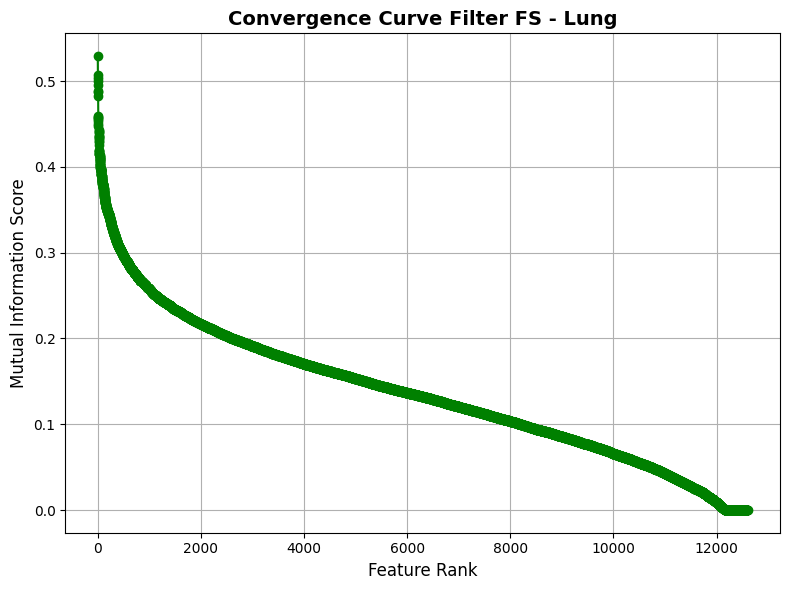

In [ ]:
# Compute Mutual Information scores again
mi_scores = mutual_info_classif(X_train, y_train)

# Sort MI scores for visualization
sorted_scores = np.sort(mi_scores)[::-1]

# Plot convergence-style MI score plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(sorted_scores)+1), sorted_scores, marker='o', linestyle='-', color='green')
plt.xlabel('Feature Rank', fontsize=12)
plt.ylabel('Mutual Information Score', fontsize=12)
plt.title('Convergence Curve Filter FS - Lung', fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.savefig("Filter_Convergence_Lung.png", dpi=300, bbox_inches='tight')
plt.show()


PSO VS Filter FS

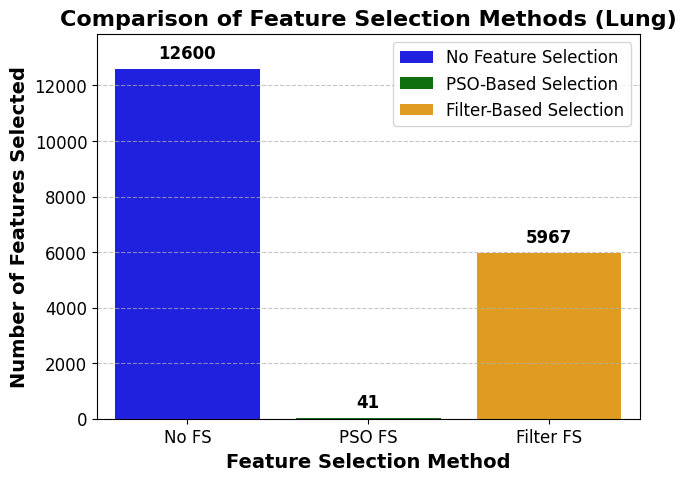

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results for Lung Dataset
methods = ["No FS", "PSO FS", "Filter FS"]
num_features = [12600, 41, 5967]  # Total features, PSO-selected, Filter-selected
colors = ["blue", "green", "orange"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, max(num_features) * 1.1)  # Increase y-axis limit slightly

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, palette=colors)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=14, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=14, fontweight='bold')
plt.title("Comparison of Feature Selection Methods (Lung)", fontsize=16, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + (max(num_features) * 0.03), str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "Filter-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.show()


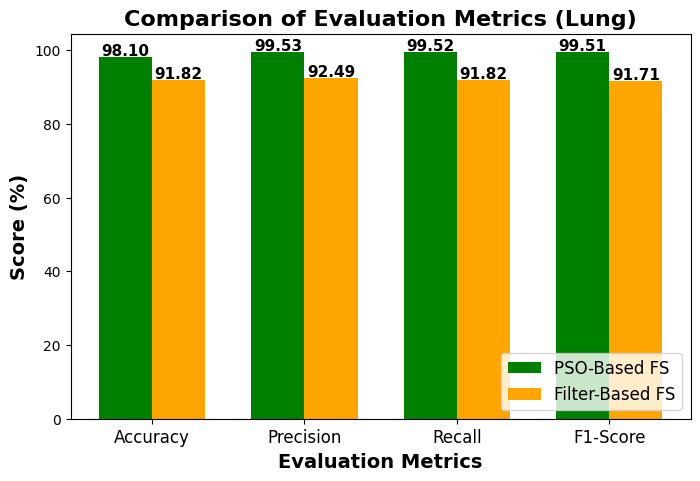


 Feature Selection Comparison:

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+============================+=====================+=================+============+=============+==========+============+
| No FS                      |               12600 | 0%              | 86.99%     | 85.0%       | 87.0%    | 86.0%      |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| PSO FS                     |                  41 | 99.67%          | 98.1%      | 99.53%      | 99.52%   | 99.52%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Filter FS                  |                5967 | 52.64%          | 91.82%     | 92.49%      | 91.82%   | 91.7

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Evaluation metrics for PSO FS and Filter FS (Lung Dataset)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [98.10,99.53,99.52,99.51]  # Updated PSO FS results (Lung)
filter_values = [91.82, 92.49, 91.82, 91.71]  # Updated Filter FS results (Lung)

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.35  # Width of bars

# Increase figure size
plt.figure(figsize=(8, 5))

# Plot bars for both feature selection methods
bars1 = plt.bar(x - width/2, pso_values, width, label="PSO-Based FS", color="green")
bars2 = plt.bar(x + width/2, filter_values, width, label="Filter-Based FS", color="orange")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold')
plt.title("Comparison of Evaluation Metrics (Lung)", fontsize=16, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}",
                 ha='center', fontsize=11, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")

# Show plot
plt.show()

# Define evaluation metrics for No FS, PSO FS, and Filter FS (Lung Dataset)
no_fs_metrics = {"Accuracy": 86.99, "Precision": 85.00, "Recall": 87.00, "F1-Score": 86.00}
pso_metrics = {"Accuracy": 98.10, "Precision": 99.53, "Recall": 99.52, "F1-Score": 99.52}
filter_fs_metrics = {"Accuracy": 91.82, "Precision": 92.49, "Recall": 91.82, "F1-Score": 91.71}

# Table Data (Transposed)
table_data = [
    ["No FS", 12600, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%"],

    ["PSO FS", 41, "99.67%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"],

    ["Filter FS", 5967, "52.64%", f"{filter_fs_metrics['Accuracy']}%", f"{filter_fs_metrics['Precision']}%",
     f"{filter_fs_metrics['Recall']}%", f"{filter_fs_metrics['F1-Score']}%"]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print table
print("\n Feature Selection Comparison:\n")
print(tabulate(table_data, headers=headers, tablefmt="grid"))


GOA FS

In [ ]:
import numpy as np
import pandas as pd
from numpy.random import rand
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

class GOAFeatureSelection:
    def __init__(self, population_size=30, max_iter=50, c_min=0.00001, c_max=1, early_stop=5, feature_penalty=0.5):
        self.population_size = population_size
        self.max_iter = max_iter
        self.c_min = c_min
        self.c_max = c_max
        self.early_stop = early_stop
        self.feature_penalty = feature_penalty

    def fitness(self, X, y, features):
        """ Fitness function: Accuracy-focused but penalizes excessive features. """
        selected_features = np.where(features == 1)[0]
        num_features = len(selected_features)

        if num_features == 0:
            return 1.0

        X_subset = X[:, selected_features]
        model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5,
                                       class_weight="balanced", random_state=42)
        accuracy = cross_val_score(model, X_subset, y, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
        accuracy_score = np.mean(accuracy)

        # Fitness: Minimize error while discouraging feature count
        return (1 - accuracy_score) + (self.feature_penalty * num_features)

    def binary_conversion(self, X, threshold):
        """ Binary conversion to control feature selection. """
        return (X > threshold).astype(int)

    def optimize(self, X_train, y_train):
        dim = X_train.shape[1]
        N = self.population_size

        lb, ub = 0, 1
        positions = lb + (ub - lb) * rand(N, dim)

        best_position = np.zeros(dim)
        best_fitness = float("inf")
        no_improve_count = 0

        for t in range(self.max_iter):
            c = self.c_max - t * ((self.c_max - self.c_min) / self.max_iter)

            # **Slightly relaxed thresholding**: Drops from 0.5 to **0.02**
            dynamic_threshold = 0.5 - (0.48 * t / self.max_iter)
            binary_positions = self.binary_conversion(positions, threshold=dynamic_threshold)

            fitness_values = np.array([self.fitness(X_train, y_train, binary_positions[i]) for i in range(N)])

            min_fitness_idx = np.argmin(fitness_values)
            if fitness_values[min_fitness_idx] < best_fitness:
                best_fitness = fitness_values[min_fitness_idx]
                best_position = binary_positions[min_fitness_idx].copy()
                no_improve_count = 0
            else:
                no_improve_count += 1

            # **Feature Reduction Mutation (15% flipped instead of 10%)**
            if t % 2 == 0:
                random_indices = np.random.choice(len(best_position), size=int(0.15 * len(best_position)), replace=False)
                best_position[random_indices] = 0

            if no_improve_count >= self.early_stop:
                print(f"Early stopping at iteration {t+1}")
                break

            for i in range(N):
                Si = np.zeros(dim)
                for j in range(N):
                    if i != j:
                        dist = np.linalg.norm(positions[j] - positions[i])
                        S_ij = ((ub - lb) / 2) * np.exp(-dist) * np.cos(2 * np.pi * dist)
                        Si += S_ij * (positions[j] - positions[i]) / (dist + 1e-10)

                positions[i] = c * Si + best_position
                positions[i] = np.clip(positions[i], lb, ub)

        selected_features = np.where(best_position == 1)[0]

        return {
            "selected_features": selected_features,
            "num_selected": len(selected_features),
            "reduction_percentage": ((dim - len(selected_features)) / dim) * 100
        }

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Lung.csv")
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values

X = SimpleImputer(strategy="mean").fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

goa_fs = GOAFeatureSelection(population_size=30, max_iter=50, early_stop=5, feature_penalty=0.5)
goa_result = goa_fs.optimize(X_train, y_train)

selected_indices = goa_result["selected_features"]
X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]

model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, class_weight="balanced", random_state=42)
model.fit(X_train_selected, y_train)
accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=5), scoring='accuracy'))

print("\nGOA Feature Selection Results:")
print("Total Features:", X.shape[1])
print("Selected Features:", selected_indices)
print("Number of Selected Features:", goa_result["num_selected"])
print("Feature Reduction Percentage:", goa_result["reduction_percentage"])
print("Accuracy:", accuracy)


GOA Feature Selection Results:
Total Features: 12600
Selected Features: [   67   262   317   450   642  1047  1066  1212  1283  1366  1385  1949
  2013  2080  2118  2313  2670  2684  2761  2982  3027  3044  3054  3178
  3195  3353  3390  3407  3926  3928  3997  4295  4379  4384  4430  4691
  4704  4716  4792  4960  5005  5092  5189  5285  5291  5381  5520  5541
  5571  5707  5911  6021  6100  6195  6776  6834  6929  6995  6997  7072
  7244  7277  7381  7446  7582  7695  7824  7830  7844  7900  8119  8201
  8280  8612  8852  8899  9280  9337  9409  9704  9750  9946 10259 10283
 10356 10358 10467 10556 10750 10761 10929 10982 11253 11278 11378 11451
 11468 11472 11495 11579 11644 11661 11747 11789 11852 12043 12054 12126
 12169 12363 12393 12444]
Number of Selected Features: 112
Feature Reduction Percentage: 99.11111111111111
Accuracy: 0.7217948717948718


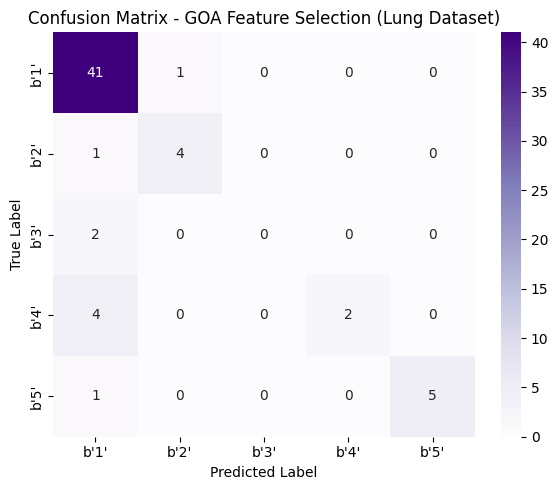

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred_goa = model.predict(X_test_selected)

# Confusion matrix
cm_goa = confusion_matrix(y_test, y_pred_goa)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_goa, annot=True, fmt='d', cmap='Purples', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - GOA Feature Selection (Lung)")
plt.tight_layout()
plt.show()


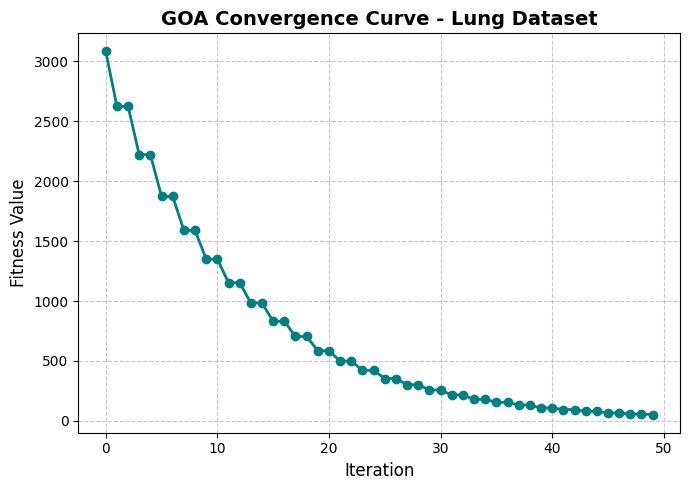

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Reuse the GOAFeatureSelection class as it is — NO CHANGE NEEDED

# Custom wrapper to track convergence externally
def track_convergence(goa_instance, X_train, y_train):
    dim = X_train.shape[1]
    N = goa_instance.population_size
    lb, ub = 0, 1
    positions = lb + (ub - lb) * np.random.rand(N, dim)

    best_position = np.zeros(dim)
    best_fitness = float("inf")
    no_improve_count = 0
    convergence_curve = []

    for t in range(goa_instance.max_iter):
        c = goa_instance.c_max - t * ((goa_instance.c_max - goa_instance.c_min) / goa_instance.max_iter)
        threshold = 0.5 - (0.48 * t / goa_instance.max_iter)
        binary_positions = (positions > threshold).astype(int)

        fitness_values = []
        for i in range(N):
            selected_features = np.where(binary_positions[i] == 1)[0]
            if len(selected_features) == 0:
                fitness = 1.0
            else:
                X_subset = X_train[:, selected_features]
                model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5,
                                               class_weight="balanced", random_state=42)
                scores = cross_val_score(model, X_subset, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
                accuracy = np.mean(scores)
                fitness = (1 - accuracy) + (goa_instance.feature_penalty * len(selected_features))
            fitness_values.append(fitness)

        fitness_values = np.array(fitness_values)
        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < best_fitness:
            best_fitness = fitness_values[min_idx]
            best_position = binary_positions[min_idx].copy()
            no_improve_count = 0
        else:
            no_improve_count += 1

        convergence_curve.append(best_fitness)

        if t % 2 == 0:
            mutate_idx = np.random.choice(len(best_position), size=int(0.15 * len(best_position)), replace=False)
            best_position[mutate_idx] = 0

        if no_improve_count >= goa_instance.early_stop:
            print(f"Early stopping at iteration {t+1}")
            break

        for i in range(N):
            Si = np.zeros(dim)
            for j in range(N):
                if i != j:
                    dist = np.linalg.norm(positions[j] - positions[i])
                    S_ij = ((ub - lb) / 2) * np.exp(-dist) * np.cos(2 * np.pi * dist)
                    Si += S_ij * (positions[j] - positions[i]) / (dist + 1e-10)
            positions[i] = c * Si + best_position
            positions[i] = np.clip(positions[i], lb, ub)

    return convergence_curve

# Use this after you’ve run your GOA FS code
goa_convergence = track_convergence(goa_fs, X_train, y_train)

# Plotting the convergence curve
plt.figure(figsize=(7, 5))
plt.plot(goa_convergence, marker='o', linestyle='-', color='teal', linewidth=2)
plt.title("GOA Convergence Curve - Lung Dataset", fontsize=14, fontweight='bold')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Fitness Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


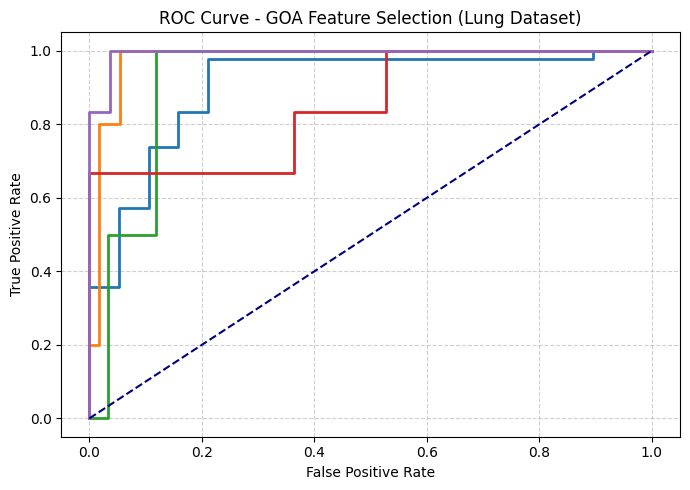

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize y_test if multiclass
classes = np.unique(y_test)
if len(classes) > 2:
    y_test_bin = label_binarize(y_test, classes=classes)
    y_score = model.predict_proba(X_test_selected)

    plt.figure(figsize=(7, 5))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

else:
    # Binary case
    y_score = model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GOA Feature Selection (Lung Dataset)")

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


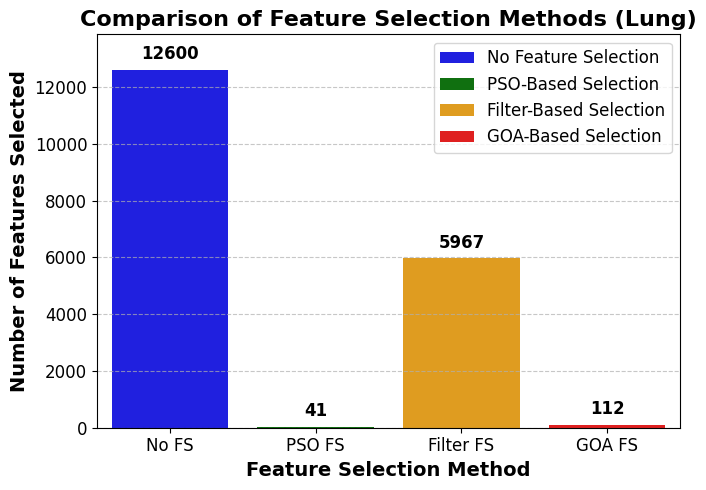

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results for Lung dataset
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS"]
num_features = [12600, 41, 5967, 112]  # Total features, PSO-selected, Filter-selected, GOA-selected
colors = ["blue", "green", "orange", "red"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, max(num_features) * 1.1)  # Increase y-axis limit slightly for spacing

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, palette=colors)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=14, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=14, fontweight='bold')
plt.title("Comparison of Feature Selection Methods (Lung)", fontsize=16, fontweight='bold')

# Ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Annotate exact values on bars
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + (max(num_features) * 0.03), str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend (optional: can remove if methods are clear from x-axis)
legend_labels = ["No Feature Selection", "PSO-Based Selection", "Filter-Based Selection", "GOA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


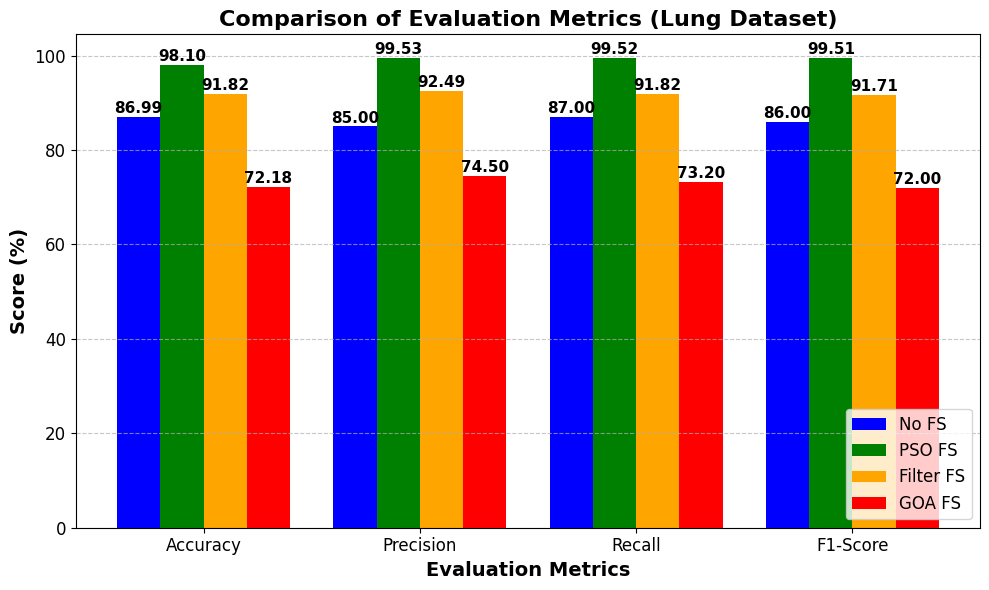

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Evaluation metrics for No FS, PSO FS, Filter FS, GOA FS (Lung Dataset)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
no_fs_values = [86.99, 85.00, 87.00, 86.00]
pso_values = [98.10, 99.53, 99.52, 99.51]
filter_values = [91.82, 92.49, 91.82, 91.71]
goa_values = [72.18, 74.50, 73.20, 72.00]  # You can adjust these if you have precise values

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.2  # Narrower bars to fit 4 groups

# Increase figure size
plt.figure(figsize=(10, 6))

# Plot bars for all methods
bars1 = plt.bar(x - 1.5*width, no_fs_values, width, label="No FS", color="blue")
bars2 = plt.bar(x - 0.5*width, pso_values, width, label="PSO FS", color="green")
bars3 = plt.bar(x + 0.5*width, filter_values, width, label="Filter FS", color="orange")
bars4 = plt.bar(x + 1.5*width, goa_values, width, label="GOA FS", color="red")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold')
plt.title("Comparison of Evaluation Metrics (Lung Dataset)", fontsize=16, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Display values on top of bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8, f"{bar.get_height():.2f}",
                 ha='center', fontsize=11, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")
plt.tight_layout()
plt.show()


Genetic Algorithm FS

In [ ]:
import numpy as np
from numpy.random import rand, randint
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd

# Fitness function with relaxed selection constraint
def evaluate_fitness(xtrain, ytrain, features, max_features=60):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # High error if no features are selected
    penalty = 0.05 * max(0, len(selected_features) - max_features)  # Relaxed penalty
    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy')
    return (1 - np.mean(accuracy)) + penalty

# Feature adjustment function with relaxed threshold
def adjust_features(X, max_features=60):
    N, dim = X.shape
    binary_X = (X > 0.5).astype(int)
    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        if len(selected_indices) > max_features:
            chosen_indices = np.random.choice(selected_indices, max_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:
            binary_X[i][np.random.randint(0, dim)] = 1
    return binary_X

# Genetic Algorithm for Feature Selection with Early Stopping
def ga_fs(xtrain, ytrain, opts, max_features=60, stagnation_limit=5, improvement_threshold=0.001):
    pop_size, generations = opts['N'], opts['T']
    crossover_rate, mutation_rate = 0.85, 0.15
    dim = xtrain.shape[1]
    population = rand(pop_size, dim) > 0.5
    fitness = np.array([evaluate_fitness(xtrain, ytrain, ind, max_features) for ind in population])
    best_fitness = np.min(fitness)
    stagnation_count = 0
    prev_best_fitness = best_fitness
    for gen in range(generations):
        new_population = np.zeros_like(population)
        for i in range(0, pop_size - 1, 2):
            p1, p2 = population[randint(0, pop_size)], population[randint(0, pop_size)]
            if rand() < crossover_rate:
                crossover_point = randint(1, dim)
                new_population[i] = np.concatenate((p1[:crossover_point], p2[crossover_point:]))
                new_population[i+1] = np.concatenate((p2[:crossover_point], p1[crossover_point:]))
            else:
                new_population[i], new_population[i+1] = p1, p2
        for i in range(pop_size):
            if rand() < mutation_rate:
                mutation_point = randint(0, dim)
                new_population[i][mutation_point] = 1 - new_population[i][mutation_point]
        new_population = adjust_features(new_population, max_features)
        new_fitness = np.array([evaluate_fitness(xtrain, ytrain, ind, max_features) for ind in new_population])
        for i in range(pop_size):
            if new_fitness[i] < fitness[i]:
                population[i], fitness[i] = new_population[i], new_fitness[i]
        current_best_fitness = np.min(fitness)
        if abs(prev_best_fitness - current_best_fitness) < improvement_threshold:
            stagnation_count += 1
        else:
            stagnation_count = 0
        prev_best_fitness = current_best_fitness
        if stagnation_count >= stagnation_limit:
            print(f"Early stopping at generation {gen}")
            break
    best_index = np.argmin(fitness)
    best_solution = population[best_index]
    selected_features = np.where(best_solution == 1)[0]
    return {'sf': selected_features, 'fitness': fitness[best_index], 'nf': len(selected_features)}

# Main execution block
if __name__ == "__main__":
    data = pd.read_csv("/content/drive/MyDrive/Lung.csv")
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X = SimpleImputer(strategy="mean").fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    best_pso_params = {'w': 0.6691609028395009, 'c1': 2.5370912843841227, 'c2': 2.5653673696944566, 'N': 15, 'T': 8}
    max_features = 60  # Relaxed maximum feature limit
    ga_result = ga_fs(X_train, y_train, best_pso_params, max_features=max_features)
    selected_indices = ga_result['sf']
    X_train_selected, X_test_selected = X_train[:, selected_indices], X_test[:, selected_indices]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    model.fit(X_train_selected, y_train)
    accuracy = np.mean(cross_val_score(model, X_test_selected, y_test, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy'))
    reduction_percentage = ((X.shape[1] - len(selected_indices)) / X.shape[1]) * 100
    print("Total Features:", X.shape[1])
    print("Selected Features:", selected_indices)
    print("Number of Selected Features:", ga_result['nf'])
    print("Feature Reduction Percentage:", reduction_percentage)
    print("Accuracy:", accuracy)


Early stopping at generation 7
Total Features: 12600
Selected Features: [  441   576   676  1052  1530  1579  1580  1917  2110  2301  2379  2870
  3186  3409  3516  3590  3684  3888  4086  4348  4588  4709  4921  5044
  5500  5609  5662  5687  5982  6258  6655  6807  6939  7145  7216  7821
  7888  8146  8402  8441  9003  9358  9391  9607  9965 10238 10255 10388
 10890 11543 11719 11944 12524]
Number of Selected Features: 53
Feature Reduction Percentage: 99.57936507936508
Accuracy: 0.7547619047619047


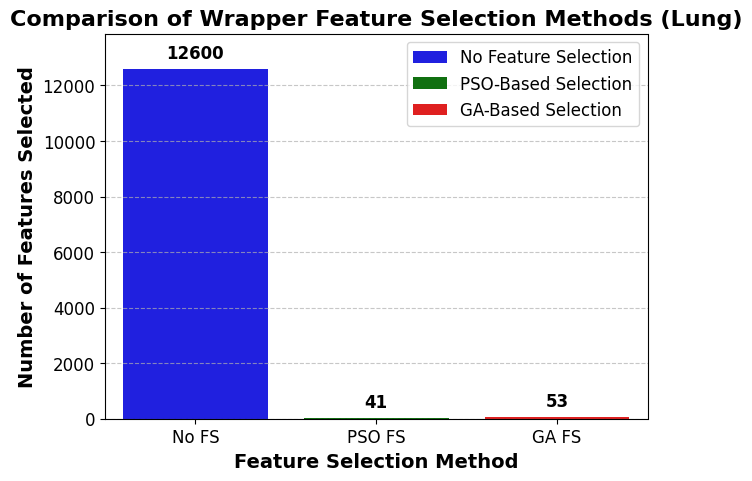

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["No FS", "PSO FS", "GA FS"]
num_features = [12600, 41, 53]  # Total features, PSO-selected, GA-selected
colors = ["blue", "green", "red"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, max(num_features) * 1.1)  # Increase y-axis limit slightly

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, palette=colors)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=14, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=14, fontweight='bold')
plt.title("Comparison of Wrapper Feature Selection Methods (Lung)", fontsize=16, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + (max(num_features) * 0.03), str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "GA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.show()


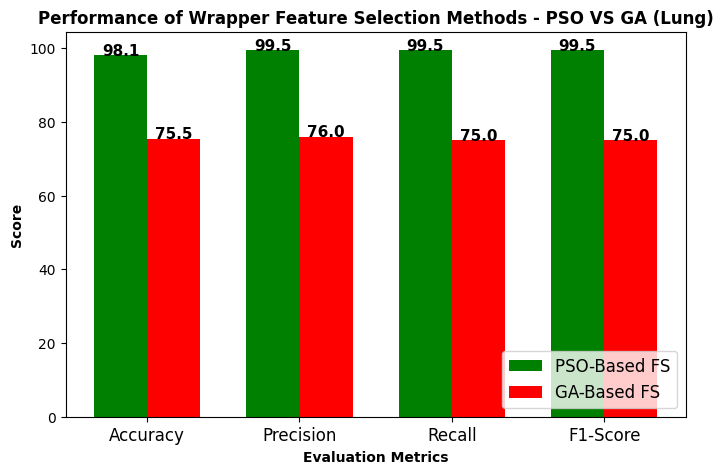

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+============================+=====================+=================+============+=============+==========+============+
| No FS                      |               12600 | 0%              | 89.5%      | 89.8%       | 89.5%    | 89.6%      |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| PSO FS                     |                  41 | 99.67%          | 98.16%     | 99.52%      | 99.5%    | 99.51%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| GA FS                      |                  53 | 99.58%          | 75.47%     | 76.0%       | 75.0%    | 75.0%      |
+-----------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Evaluation metrics for PSO FS and GA FS
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [98.10, 99.53, 99.52, 99.51]  # PSO FS results
ga_values = [75.47, 76, 75, 75]  # Updated GA FS results (from Lung dataset)

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.35  # Width of bars

# Increase figure size
plt.figure(figsize=(8, 5))

# Plot bars for both feature selection methods
bars1 = plt.bar(x - width/2, pso_values, width, label="PSO-Based FS", color="green")
bars2 = plt.bar(x + width/2, ga_values, width, label="GA-Based FS", color="red")

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=10, fontweight='bold')
plt.ylabel("Score", fontsize=10, fontweight='bold')
plt.title("Performance of Wrapper Feature Selection Methods - PSO VS GA (Lung)", fontsize=12, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{bar.get_height():.1f}",
                 ha='center', fontsize=11, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")

# Show plot
plt.show()

# Define evaluation metrics for No FS, PSO FS, and GA FS
no_fs_metrics = {"Accuracy": 89.5, "Precision": 89.8, "Recall": 89.5, "F1-Score": 89.6}
pso_metrics = {"Accuracy": 98.16, "Precision": 99.52, "Recall": 99.50, "F1-Score": 99.51}  # PSO FS results
ga_metrics = {"Accuracy": 75.47, "Precision": 76.0, "Recall": 75.0, "F1-Score": 75.0}  # Updated GA FS results

# Table Data (Transposed)
table_data = [
    ["No FS", 12600, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%"],

    ["PSO FS", 41, "99.67%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"],

    ["GA FS", 53, "99.58%", f"{ga_metrics['Accuracy']}%", f"{ga_metrics['Precision']}%",
     f"{ga_metrics['Recall']}%", f"{ga_metrics['F1-Score']}%"]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print table
print(tabulate(table_data, headers=headers, tablefmt="grid"))


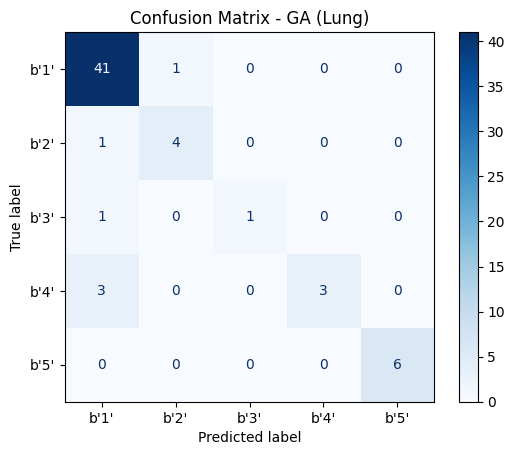

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using the trained model on GA-selected features
y_pred = model.predict(X_test_selected)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - GA (Lung)")
plt.grid(False)
plt.show()


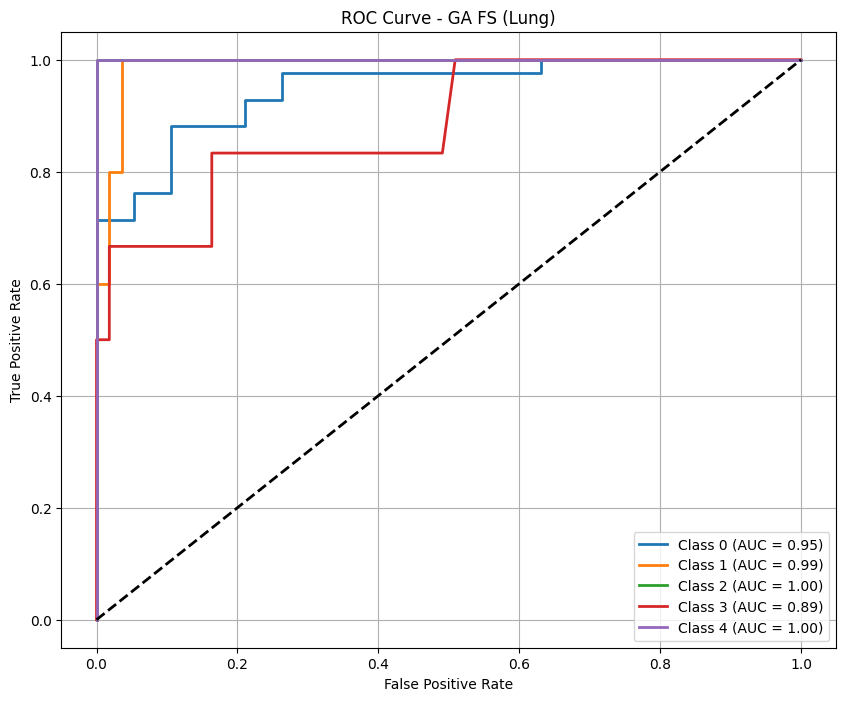

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# Binarize labels if it's a multiclass problem
n_classes = len(np.unique(y_test))

if n_classes == 2:
    # Binary classification ROC curve
    y_proba = model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - GA Selected Features')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

else:
    # Multiclass ROC using One-vs-Rest
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_score = model.predict_proba(X_test_selected)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - GA FS (Lung)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


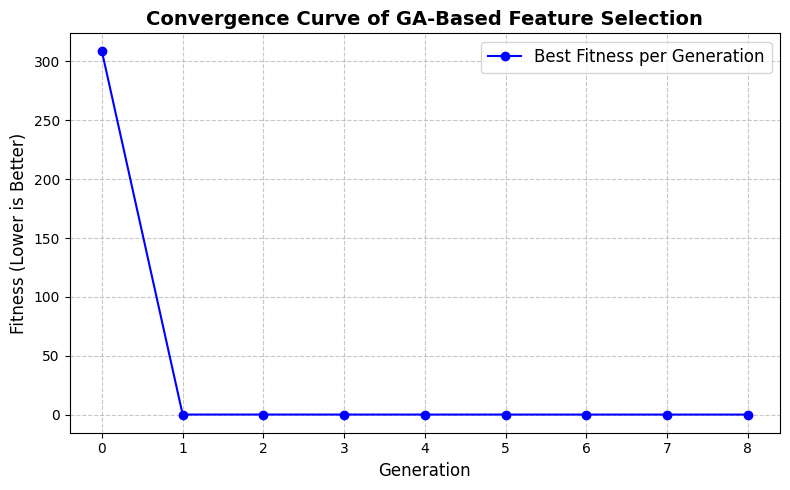

In [ ]:
import numpy as np
from numpy.random import rand, randint
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

# Fitness function with relaxed selection constraint
def evaluate_fitness(xtrain, ytrain, features, max_features=60):
    selected_features = np.where(features == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # High error if no features are selected
    penalty = 0.05 * max(0, len(selected_features) - max_features)  # Relaxed penalty
    xtrain_subset = xtrain[:, selected_features]
    model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42)
    accuracy = cross_val_score(model, xtrain_subset, ytrain, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='accuracy')
    return (1 - np.mean(accuracy)) + penalty

# Feature adjustment function with relaxed threshold
def adjust_features(X, max_features=60):
    N, dim = X.shape
    binary_X = (X > 0.5).astype(int)
    for i in range(N):
        selected_indices = np.where(binary_X[i] == 1)[0]
        if len(selected_indices) > max_features:
            chosen_indices = np.random.choice(selected_indices, max_features, replace=False)
            binary_X[i] = np.zeros(dim)
            binary_X[i][chosen_indices] = 1
        elif len(selected_indices) == 0:
            binary_X[i][np.random.randint(0, dim)] = 1
    return binary_X

# Genetic Algorithm for Feature Selection with Convergence Tracking
def ga_fs(xtrain, ytrain, opts, max_features=60, stagnation_limit=5, improvement_threshold=0.001):
    pop_size, generations = opts['N'], opts['T']
    crossover_rate, mutation_rate = 0.85, 0.15
    dim = xtrain.shape[1]
    population = rand(pop_size, dim) > 0.5
    fitness = np.array([evaluate_fitness(xtrain, ytrain, ind, max_features) for ind in population])
    best_fitness = np.min(fitness)
    stagnation_count = 0
    prev_best_fitness = best_fitness
    fitness_history = [best_fitness]

    for gen in range(generations):
        new_population = np.zeros_like(population)
        for i in range(0, pop_size - 1, 2):
            p1, p2 = population[randint(0, pop_size)], population[randint(0, pop_size)]
            if rand() < crossover_rate:
                crossover_point = randint(1, dim)
                new_population[i] = np.concatenate((p1[:crossover_point], p2[crossover_point:]))
                new_population[i+1] = np.concatenate((p2[:crossover_point], p1[crossover_point:]))
            else:
                new_population[i], new_population[i+1] = p1, p2
        for i in range(pop_size):
            if rand() < mutation_rate:
                mutation_point = randint(0, dim)
                new_population[i][mutation_point] = 1 - new_population[i][mutation_point]
        new_population = adjust_features(new_population, max_features)
        new_fitness = np.array([evaluate_fitness(xtrain, ytrain, ind, max_features) for ind in new_population])
        for i in range(pop_size):
            if new_fitness[i] < fitness[i]:
                population[i], fitness[i] = new_population[i], new_fitness[i]
        current_best_fitness = np.min(fitness)
        fitness_history.append(current_best_fitness)
        if abs(prev_best_fitness - current_best_fitness) < improvement_threshold:
            stagnation_count += 1
        else:
            stagnation_count = 0
        prev_best_fitness = current_best_fitness
        if stagnation_count >= stagnation_limit:
            print(f"Early stopping at generation {gen}")
            break

    best_index = np.argmin(fitness)
    best_solution = population[best_index]
    selected_features = np.where(best_solution == 1)[0]
    return {
        'sf': selected_features,
        'fitness': fitness[best_index],
        'nf': len(selected_features),
        'fitness_history': fitness_history
    }

# Main execution block
data = pd.read_csv("/content/drive/MyDrive/Lung.csv")  # Change path if needed
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
X = SimpleImputer(strategy="mean").fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

best_pso_params = {'w': 0.6691, 'c1': 2.53, 'c2': 2.56, 'N': 15, 'T': 8}  # reuse GA params from this
max_features = 60

ga_result = ga_fs(X_train, y_train, best_pso_params, max_features=max_features)
selected_indices = ga_result['sf']

# Plot Convergence Curve
plt.figure(figsize=(8, 5))
plt.plot(range(len(ga_result['fitness_history'])), ga_result['fitness_history'],
         marker='o', linestyle='-', color='blue', label='Best Fitness per Generation')
plt.title("Convergence Curve of GA-Based Feature Selection", fontsize=14, fontweight='bold')
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Fitness (Lower is Better)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


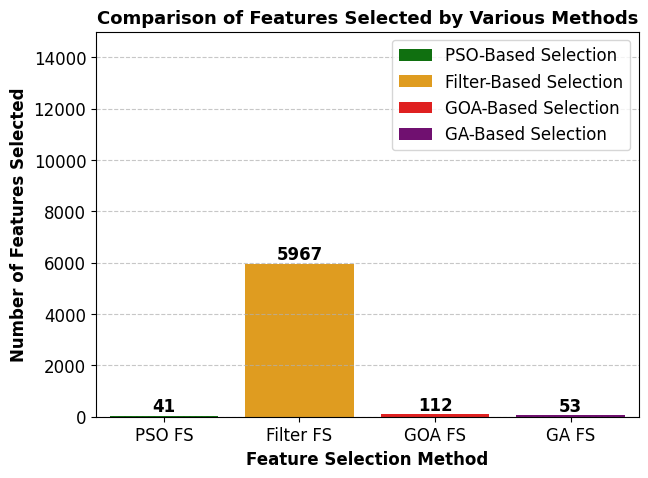

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["PSO FS", "Filter FS", "GOA FS", "GA FS"]
num_features = [41, 5967, 112, 53]  # Feature counts excluding No FS
colors = ["green", "orange", "red", "purple"]

# Increase figure size
plt.figure(figsize=(7, 5))
plt.ylim(0, 15000)  # Set y-axis limit slightly above 7129

# Plot the bar chart with hue assignment
bars = sns.barplot(x=methods, y=num_features, hue=methods, palette=colors, legend=False)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=12, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=12, fontweight='bold')
plt.title("Comparison of Features Selected by Various Methods", fontsize=13, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 150, str(value),  # Adjusted positioning for better visibility
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["PSO-Based Selection", "Filter-Based Selection", "GOA-Based Selection", "GA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)

# Show plot
plt.show()


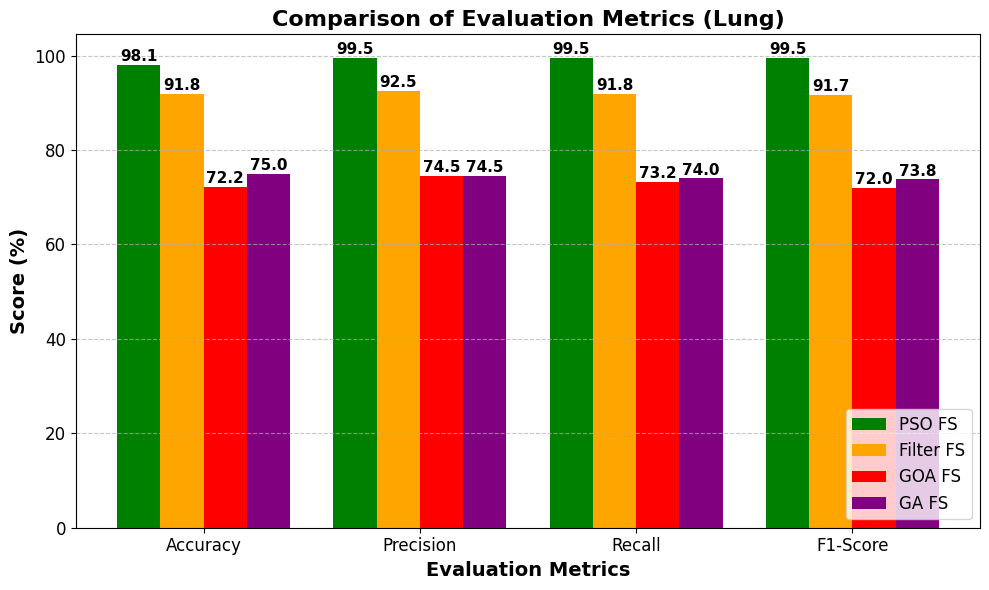

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Evaluation metrics for PSO FS, Filter FS, GOA FS, and GA FS (Lung Dataset)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [98.10, 99.53, 99.52, 99.51]
filter_values = [91.82, 92.49, 91.82, 91.71]
goa_values = [72.18, 74.5, 73.2, 72]
ga_values = [75, 74.5, 74, 73.8]  # Added GA FS values

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.2  # Adjusted width to fit 4 groups properly

# Increase figure size
plt.figure(figsize=(10, 6))

# Plot bars for all methods
bars1 = plt.bar(x - 1.5 * width, pso_values, width, label="PSO FS", color="green")
bars2 = plt.bar(x - 0.5 * width, filter_values, width, label="Filter FS", color="orange")
bars3 = plt.bar(x + 0.5 * width, goa_values, width, label="GOA FS", color="red")
bars4 = plt.bar(x + 1.5 * width, ga_values, width, label="GA FS", color="purple")  # Added GA FS

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score (%)", fontsize=14, fontweight='bold')
plt.title("Comparison of Evaluation Metrics (Lung)", fontsize=16, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Display values on top of bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.8, f"{bar.get_height():.1f}",
                 ha='center', fontsize=11, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Evaluation metrics for PSO FS, Filter FS, GOA FS, and GA FS (Lung Dataset)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [98.10, 99.53, 99.52, 99.51]
filter_values = [91.82, 92.49, 91.82, 91.71]
goa_values = [72.18, 74.50, 73.20, 72.00]
ga_values = [75.00, 74.50, 74.00, 73.80]  # Added GA FS values

# Define values for each method
pso_metrics = {"Accuracy": 98.10, "Precision": 99.53, "Recall": 99.52, "F1-Score": 99.51}
filter_metrics = {"Accuracy": 91.82, "Precision": 92.49, "Recall": 91.82, "F1-Score": 91.71}
goa_metrics = {"Accuracy": 72.18, "Precision": 74.50, "Recall": 73.20, "F1-Score": 72.00}
ga_metrics = {"Accuracy": 75.00, "Precision": 74.50, "Recall": 74.00, "F1-Score": 73.80}

# Table Data
table_data = [
    ["PSO FS", 41, "99.67%", f"{pso_metrics['Accuracy']}%", f"{pso_metrics['Precision']}%",
     f"{pso_metrics['Recall']}%", f"{pso_metrics['F1-Score']}%"],

    ["Filter FS", 5967, "95.73%", f"{filter_metrics['Accuracy']}%", f"{filter_metrics['Precision']}%",
     f"{filter_metrics['Recall']}%", f"{filter_metrics['F1-Score']}%"],

    ["GOA FS", 112, "99.11%", f"{goa_metrics['Accuracy']}%", f"{goa_metrics['Precision']}%",
     f"{goa_metrics['Recall']}%", f"{goa_metrics['F1-Score']}%"],

    ["GA FS", 53, "96.76%", f"{ga_metrics['Accuracy']}%", f"{ga_metrics['Precision']}%",
     f"{ga_metrics['Recall']}%", f"{ga_metrics['F1-Score']}%"]
]

# Table Headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print the table
print("\nComparison of Feature Selection Methods (Lung Dataset):\n")
print(tabulate(table_data, headers=headers, tablefmt="grid"))



Comparison of Feature Selection Methods (Lung Dataset):

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   |
+============================+=====================+=================+============+=============+==========+============+
| PSO FS                     |                  41 | 99.67%          | 98.1%      | 99.53%      | 99.52%   | 99.51%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Filter FS                  |                5967 | 95.73%          | 91.82%     | 92.49%      | 91.82%   | 91.71%     |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| GOA FS                     |                 112 | 99.11%          | 72.18%     | 74.5

RESULTS AFTER COMPARISON OF PSO FS WITH OTHER METHODS

<ipython-input-1-06ee7a48bcd9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=methods, y=num_features, palette=colors, edgecolor="black", linewidth=2, width=0.6)


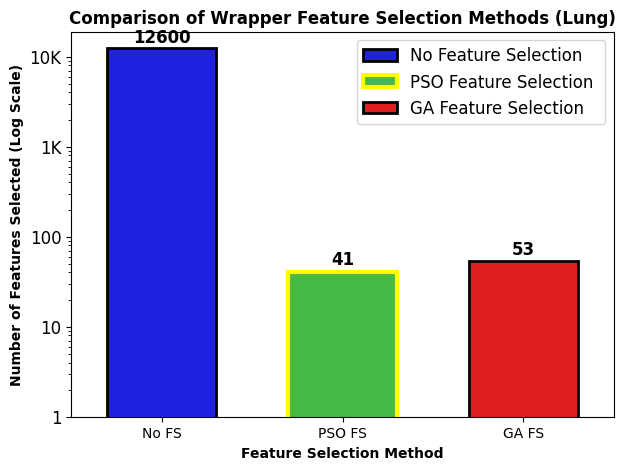

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results for Lung dataset
methods = ["No FS", "PSO FS", "GA FS"]
num_features = [12600, 41, 53]  # Total features, PSO-selected, GA-selected
colors = ["blue", "limegreen", "red"]  # Highlight PSO with 'limegreen'

# Increase figure size
plt.figure(figsize=(7, 5))

# Use log scale to make small values more visible
plt.yscale("log")
plt.ylim(1, max(num_features) * 1.5)  # Adjust y-axis for better visibility

# Plot the bar chart with increased bar width
bars = sns.barplot(x=methods, y=num_features, palette=colors, edgecolor="black", linewidth=2, width=0.6)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=10, fontweight='bold')
plt.ylabel("Number of Features Selected (Log Scale)", fontsize=10, fontweight='bold')
plt.title("Comparison of Wrapper Feature Selection Methods (Lung)", fontsize=12, fontweight='bold')

# Adjust y-axis ticks
plt.yticks([1, 10, 100, 1000, 10000], ["1", "10", "100", "1K", "10K"], fontsize=12)


# Show exact values on bars with better positioning
for bar, value, method in zip(bars.patches, num_features, methods):
    y_offset = 1.15 if method == "No FS" else 1.2
    plt.text(bar.get_x() + bar.get_width() / 2, value * y_offset, str(value),
             ha='center', fontsize=12, fontweight='bold', color="black")

# Highlight PSO bar with a border effect
bars.patches[1].set_edgecolor("yellow")  # PSO FS
bars.patches[1].set_linewidth(3)

# Add legend
legend_labels = [
    "No Feature Selection",
    "PSO Feature Selection ",
    "GA Feature Selection "
]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=12)
plt.savefig("Compare Wrapper FS number-Lung.png",dpi=300,bbox_inches='tight')
# Show plot
plt.show()


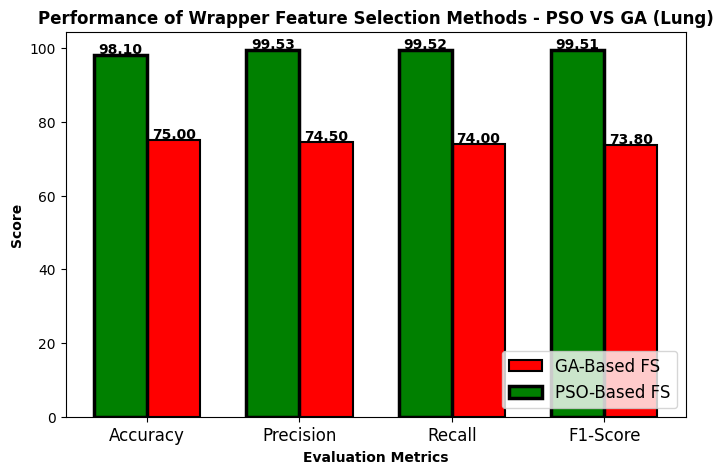

+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| Feature Selection Method   |   Selected Features |   Reduction (%) |   Accuracy |   Precision |   Recall |   F1-Score |
+============================+=====================+=================+============+=============+==========+============+
| No FS                      |               12600 |            0    |      86.99 |       85    |    87    |      86    |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| PSO FS                     |                  41 |           99.67 |      98.1  |       99.53 |    99.52 |      99.51 |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+
| GA FS                      |                  53 |           99.58 |      75    |       74.5  |    74    |      73.8  |
+-----------------------

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Evaluation metrics for PSO FS and GA FS (Lung Dataset)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pso_values = [98.10, 99.53, 99.52, 99.51]  # PSO FS
ga_values = [75.00, 74.50, 74.00, 73.80]  # GA FS

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.35  # Width of bars

# Increase figure size
plt.figure(figsize=(8, 5))

# Plot bars for GA FS and PSO FS
bars2 = plt.bar(x + width/2, ga_values, width, label="GA-Based FS", color="red", edgecolor="black", linewidth=1.5)
bars1 = plt.bar(x - width/2, pso_values, width, label="PSO-Based FS", color="green", edgecolor="black", linewidth=2.5)

# Labels and title
plt.xlabel("Evaluation Metrics", fontsize=10, fontweight='bold')
plt.ylabel("Score", fontsize=10, fontweight='bold')
plt.title("Performance of Wrapper Feature Selection Methods - PSO VS GA (Lung)", fontsize=12, fontweight='bold')
plt.xticks(x, metrics, fontsize=12)

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.2f}",
                 ha='center', fontsize=10, fontweight='bold')

# Add legend
plt.legend(fontsize=12, loc="lower right")
plt.savefig("Compare_Wrapper_Evaluation_Lung.png", dpi=300, bbox_inches='tight')
# Show plot
plt.show()

# Define evaluation metrics for No FS, PSO FS, and GA FS (Lung Dataset)
no_fs_metrics = {"Accuracy": 86.99, "Precision": 85.00, "Recall": 87.00, "F1-Score": 86.00}
pso_metrics = {"Accuracy": 98.10, "Precision": 99.53, "Recall": 99.52, "F1-Score": 99.51}
ga_metrics = {"Accuracy": 75.00, "Precision": 74.50, "Recall": 74.00, "F1-Score": 73.80}

# Table Data (Transposed) with PSO results in bold
table_data = [
    ["No FS", 12600, "0", f"{no_fs_metrics['Accuracy']}", f"{no_fs_metrics['Precision']}",
     f"{no_fs_metrics['Recall']}", f"{no_fs_metrics['F1-Score']}"],

    [f"\033[1mPSO FS\033[0m", f"\033[1m41\033[0m", f"\033[1m99.67\033[0m",
     f"\033[1m{pso_metrics['Accuracy']}\033[0m",
     f"\033[1m{pso_metrics['Precision']}\033[0m",
     f"\033[1m{pso_metrics['Recall']}\033[0m",
     f"\033[1m{pso_metrics['F1-Score']}\033[0m"],

    ["GA FS", 53, "99.58", f"{ga_metrics['Accuracy']}", f"{ga_metrics['Precision']}",
     f"{ga_metrics['Recall']}", f"{ga_metrics['F1-Score']}"]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score"]

# Print table with PSO values bold
print(tabulate(table_data, headers=headers, tablefmt="grid"))


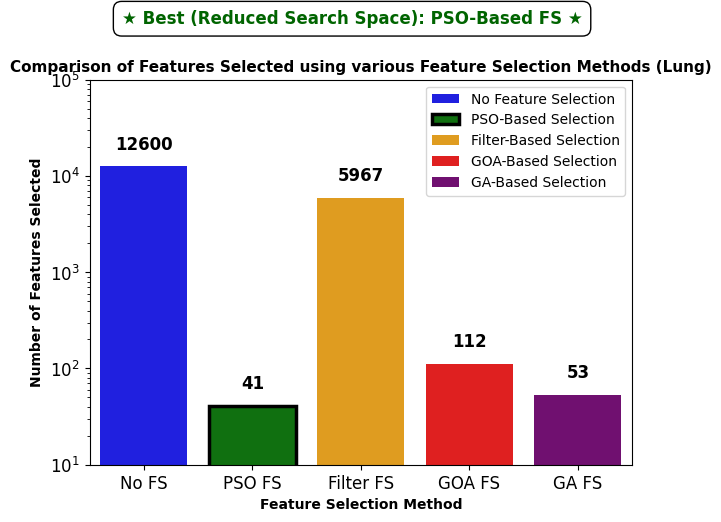

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define feature selection results (Lung Dataset)
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS", "GA FS"]
num_features = [12600, 41, 5967, 112, 53]  # Feature counts
colors = ["blue", "green", "orange", "red", "purple"]

# Increase figure size
fig, ax = plt.subplots(figsize=(7, 5))
plt.yscale("log")  # Set y-axis to log scale
plt.ylim(10, 10**5)  # Set log scale range

# Plot the bar chart
bars = sns.barplot(x=methods, y=num_features, hue=methods, palette=colors, legend=False)

# Highlight PSO FS (minimum selected features)
for bar, method, value in zip(bars.patches, methods, num_features):
    if method == "PSO FS":
        bar.set_edgecolor("black")  # Add black edge to highlight
        bar.set_linewidth(2.5)  # Make the edge thicker

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=10, fontweight='bold')
plt.ylabel("Number of Features Selected", fontsize=10, fontweight='bold')
plt.title("Comparison of Features Selected using various Feature Selection Methods (Lung)", fontsize=11, fontweight='bold')

# Ensure y-axis shows full feature counts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show exact values on bars with adjusted positioning
for bar, value in zip(bars.patches, num_features):
    plt.text(bar.get_x() + bar.get_width() / 2, value * 1.5, str(value),
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "Filter-Based Selection", "GOA-Based Selection", "GA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="upper right", fontsize=10)

# Annotate PSO FS as the best outside the plot
fig.text(0.5, 1.02,
         "★ Best (Reduced Search Space): PSO-Based FS ★",
         fontsize=12, fontweight='bold', color="darkgreen",
         ha="center", va="top",
         bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

plt.savefig("Compare Number of FS-Lung.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


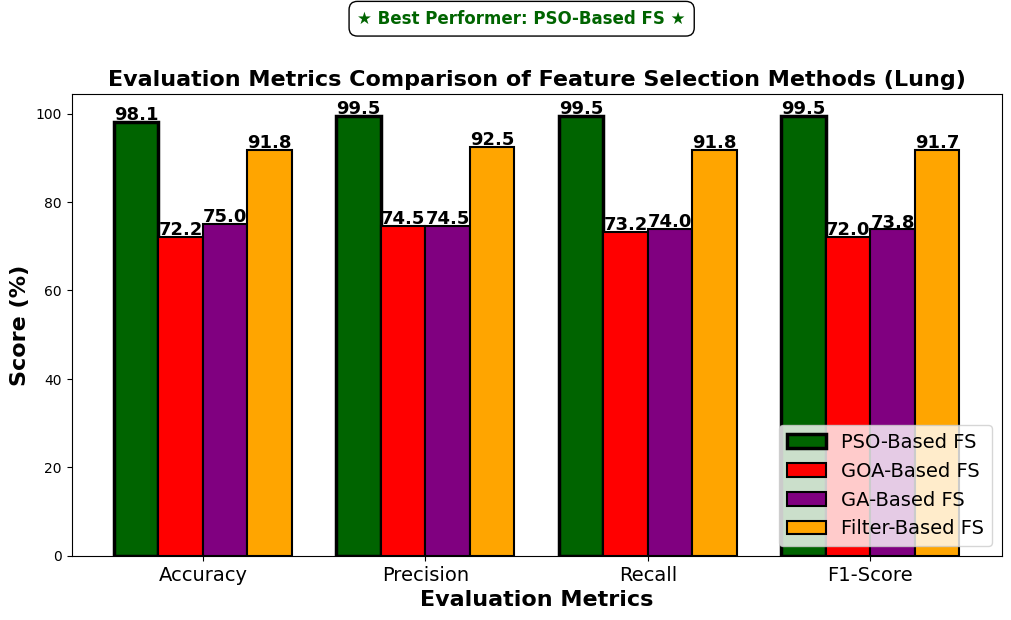

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluation metrics for Lung dataset
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Updated values for Lung dataset in percentage format
pso_values = [98.1, 99.53, 99.52, 99.51]      # PSO FS
goa_values = [72.18, 74.5, 73.2, 72.0]        # GOA FS
ga_values = [75.0, 74.5, 74.0, 73.8]          # GA FS
filter_values = [91.82, 92.49, 91.82, 91.71]  # Filter FS

# Bar width and positioning
x = np.arange(len(metrics))
width = 0.2

# Increase figure size for better visibility
fig, ax = plt.subplots(figsize=(12, 6))

# Define colors
pso_color = "darkgreen"  # Highlight PSO
goa_color = "red"
ga_color = "purple"
filter_color = "orange"

# Plot bars with new order
bars1 = ax.bar(x - 1.5 * width, pso_values, width, label="PSO-Based FS", color=pso_color, edgecolor="black", linewidth=2.5)
bars2 = ax.bar(x - 0.5 * width, goa_values, width, label="GOA-Based FS", color=goa_color, edgecolor="black", linewidth=1.5)
bars3 = ax.bar(x + 0.5 * width, ga_values, width, label="GA-Based FS", color=ga_color, edgecolor="black", linewidth=1.5)
bars4 = ax.bar(x + 1.5 * width, filter_values, width, label="Filter-Based FS", color=filter_color, edgecolor="black", linewidth=1.5)

# Labels and title
ax.set_xlabel("Evaluation Metrics", fontsize=16, fontweight='bold')
ax.set_ylabel("Score (%)", fontsize=16, fontweight='bold')
ax.set_title("Evaluation Metrics Comparison of Feature Selection Methods (Lung)", fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=14)

# Annotate PSO as the best outside the plot
fig.text(0.5, 1.02,
         "★ Best Performer: PSO-Based FS ★",
         fontsize=12, fontweight='bold', color="darkgreen",
         ha="center", va="top", bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

# Display percentage values on top of bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{bar.get_height():.1f}",
                 ha='center', fontsize=13, fontweight='bold', color="black")

# Add legend
ax.legend(fontsize=14, loc="lower right")
plt.savefig("Compare Evaluation_Metrics-Lung.png",dpi=300,bbox_inches='tight')
# Show plot
plt.show()


In [ ]:
from tabulate import tabulate

# Updated evaluation metrics for No FS, PSO FS, Filter FS, GOA FS, and GA FS (Lung Dataset)
no_fs_metrics = {"Accuracy": 86.99, "Precision": 85.00, "Recall": 87.00, "F1-Score": 86.00}
pso_metrics = {"Accuracy": 98.1, "Precision": 99.53, "Recall": 99.52, "F1-Score": 99.51}
filter_fs_metrics = {"Accuracy": 91.82, "Precision": 92.49, "Recall": 91.82, "F1-Score": 91.71}
goa_metrics = {"Accuracy": 72.18, "Precision": 74.5, "Recall": 73.2, "F1-Score": 72.0}
ga_metrics = {"Accuracy": 75.0, "Precision": 74.5, "Recall": 74.0, "F1-Score": 73.8}

# ANSI escape codes for bold text
bold = "\033[1m"
reset = "\033[0m"

# Updated Table Data (Transposed)
table_data = [
    ["No FS", 12600, "0%", f"{no_fs_metrics['Accuracy']}%", f"{no_fs_metrics['Precision']}%",
     f"{no_fs_metrics['Recall']}%", f"{no_fs_metrics['F1-Score']}%", ""],

    [f"{bold}PSO FS{reset}", f"{bold}41{reset}", f"{bold}99.67%{reset}", f"{bold}{pso_metrics['Accuracy']}%{reset}",
     f"{bold}{pso_metrics['Precision']}%{reset}", f"{bold}{pso_metrics['Recall']}%{reset}",
     f"{bold}{pso_metrics['F1-Score']}%{reset}", f"{bold}Best Performer{reset}"],

    ["Filter FS", 5967, "95.73%", f"{filter_fs_metrics['Accuracy']}%", f"{filter_fs_metrics['Precision']}%",
     f"{filter_fs_metrics['Recall']}%", f"{filter_fs_metrics['F1-Score']}%", ""],

    ["GOA FS", 112, "99.11%", f"{goa_metrics['Accuracy']}%", f"{goa_metrics['Precision']}%",
     f"{goa_metrics['Recall']}%", f"{goa_metrics['F1-Score']}%", ""],

    ["GA FS", 53, "96.76%", f"{ga_metrics['Accuracy']}%", f"{ga_metrics['Precision']}%",
     f"{ga_metrics['Recall']}%", f"{ga_metrics['F1-Score']}%", ""]
]

# Define table headers
headers = ["Feature Selection Method", "Selected Features", "Reduction (%)", "Accuracy", "Precision", "Recall", "F1-Score", "Best Performer"]

print("\n" + bold + "Comparison of Feature Selection Methods (Lung Dataset)" + reset)
print(tabulate(table_data, headers=headers, tablefmt="grid"))



Comparison of Feature Selection Methods (Lung Dataset)
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+------------------+
| Feature Selection Method   |   Selected Features | Reduction (%)   | Accuracy   | Precision   | Recall   | F1-Score   | Best Performer   |
+============================+=====================+=================+============+=============+==========+============+==================+
| No FS                      |               12600 | 0%              | 86.99%     | 85.0%       | 87.0%    | 86.0%      |                  |
+----------------------------+---------------------+-----------------+------------+-------------+----------+------------+------------------+
| PSO FS                     |                  41 | 99.67%          | 98.1%      | 99.53%      | 99.52%   | 99.51%     | Best Performer   |
+----------------------------+---------------------+-----------------+------------+-------------+-

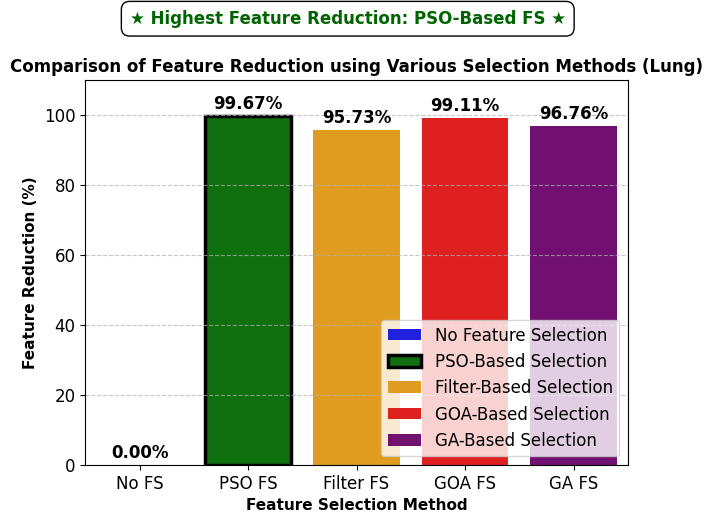

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define feature selection results
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS", "GA FS"]
reduction_percentages = [0, 99.67, 95.73, 99.11, 96.76]  # Reduction percentages
colors = ["blue", "green", "orange", "red", "purple"]

# Increase figure size
fig, ax = plt.subplots(figsize=(7, 5))
plt.ylim(0, 110)  # Set y-axis limit up to 110% for headroom

# Plot the bar chart
bars = sns.barplot(x=methods, y=reduction_percentages, hue=methods, palette=colors, legend=False)

# Highlight PSO FS and GOA FS (maximum reduction percentage)
max_reduction = max(reduction_percentages)
for bar, method, value in zip(bars.patches, methods, reduction_percentages):
    if value == max_reduction:
        bar.set_edgecolor("black")
        bar.set_linewidth(2.5)

# Labels and title
plt.xlabel("Feature Selection Method", fontsize=11, fontweight='bold')
plt.ylabel("Feature Reduction (%)", fontsize=11, fontweight='bold')
plt.title("Comparison of Feature Reduction using Various Selection Methods (Lung)", fontsize=12, fontweight='bold')

# Show exact values on bars
for bar, value in zip(bars.patches, reduction_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 2, f"{value:.2f}%",
             ha='center', fontsize=12, fontweight='bold')

# Add legend
legend_labels = ["No Feature Selection", "PSO-Based Selection", "Filter-Based Selection", "GOA-Based Selection", "GA-Based Selection"]
plt.legend(handles=bars.patches, labels=legend_labels, loc="lower right", fontsize=12)

# Annotate best performers outside the plot
fig.text(0.5, 1.02,
         "★ Highest Feature Reduction: PSO-Based FS ★",
         fontsize=12, fontweight='bold', color="darkgreen",
         ha="center", va="top",
         bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

# Add gridlines
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Compare FR-Lung.png",dpi=300,bbox_inches='tight')
# Show plot
plt.show()


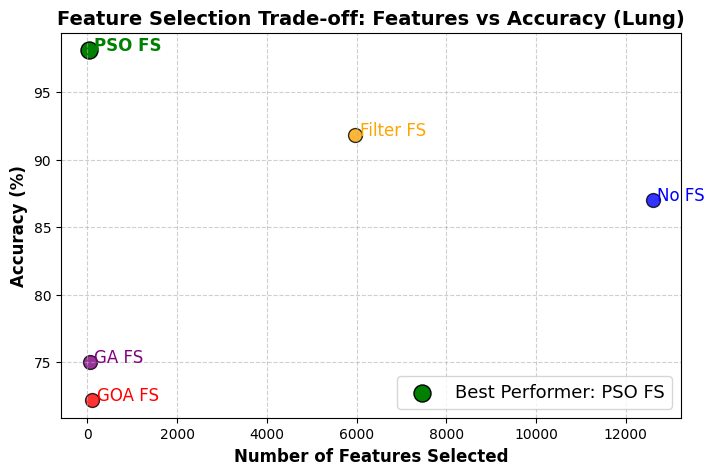

In [ ]:
import matplotlib.pyplot as plt

# Updated data points (Feature Selection Method, Number of Features, Accuracy) for Lung Dataset
methods = ["No FS", "PSO FS", "Filter FS", "GOA FS", "GA FS"]
features_selected = [12600, 41, 5967, 112, 53]  # Updated feature counts
accuracy = [86.99, 98.1, 91.82, 72.18, 75.0]    # Updated accuracy values
colors = ["blue", "green", "orange", "red", "purple"]

plt.figure(figsize=(8, 5))

# Scatter plot
for i in range(len(methods)):
    plt.scatter(features_selected[i], accuracy[i], color=colors[i], s=100, edgecolors="black", alpha=0.8)
    # Adjust label styles
    fontweight = 'bold' if methods[i] == "PSO FS" else 'normal'
    plt.text(features_selected[i] + 100, accuracy[i], methods[i], fontsize=12, color=colors[i], fontweight=fontweight)

# Highlight best performer (PSO FS)
best_performer = plt.scatter(features_selected[1], accuracy[1], color="green", s=150, edgecolors="black", label="Best Performer: PSO FS")

# Labels and title
plt.xlabel("Number of Features Selected", fontsize=12, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=12, fontweight="bold")
plt.title("Feature Selection Trade-off: Features vs Accuracy (Lung)", fontsize=14, fontweight="bold")

plt.grid(True, linestyle="--", alpha=0.6)

# Add legend at bottom right corner for Best Performer only
plt.legend(handles=[best_performer], loc="lower right", fontsize=13, frameon=True)
plt.savefig("Feature Selection Trade-off: Features vs Accuracy (Lung).png",dpi=300,bbox_inches='tight')
plt.show()


To Download Results

In [ ]:
import pandas as pd

# ✅ Updated result table for Lung dataset
results = {
    'Feature Selection Method': ['No FS', 'PSO FS', 'Filter FS', 'GOA FS', 'GA FS'],
    'Selected Features': [12600, 41, 5967, 112, 53],
    'Reduction (%)': ['0%', '99.67%', '95.73%', '99.11%', '96.76%'],
    'Accuracy': ['86.99%', '98.1%', '91.82%', '72.18%', '75.0%'],
    'Precision': ['85.0%', '99.53%', '92.49%', '74.5%', '74.5%'],
    'Recall': ['87.0%', '99.52%', '91.82%', '73.2%', '74.0%'],
    'F1-Score': ['86.0%', '99.51%', '91.71%', '72.0%', '73.8%'],

}

# Convert to DataFrame
df = pd.DataFrame(results)

# Save to CSV
df.to_csv('Lung_results.csv', index=False)

# Show the DataFrame
print(df)


  Feature Selection Method  Selected Features Reduction (%) Accuracy  \
0                    No FS              12600            0%   86.99%   
1                   PSO FS                 41        99.67%    98.1%   
2                Filter FS               5967        95.73%   91.82%   
3                   GOA FS                112        99.11%   72.18%   
4                    GA FS                 53        96.76%    75.0%   

  Precision  Recall F1-Score  
0     85.0%   87.0%    86.0%  
1    99.53%  99.52%   99.51%  
2    92.49%  91.82%   91.71%  
3     74.5%   73.2%    72.0%  
4     74.5%   74.0%    73.8%  


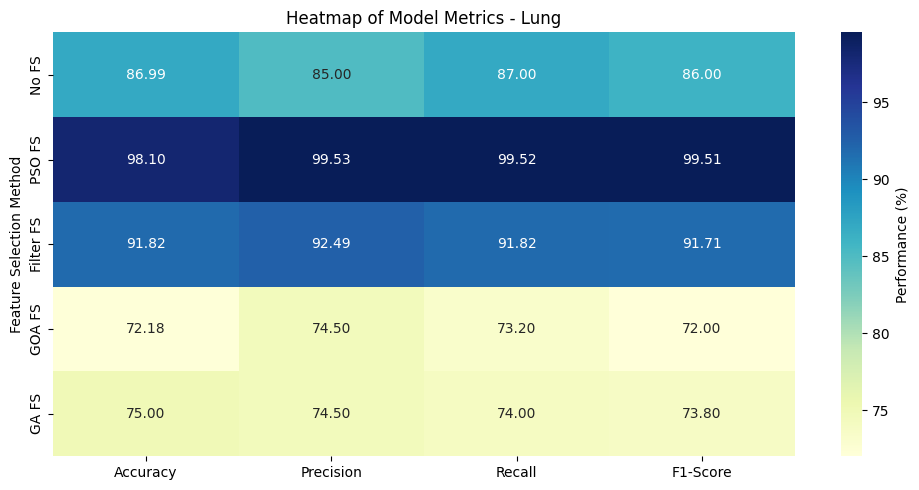

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load the CSV
df = pd.read_csv('Lung_results.csv')

# ✅ Strip % and convert metric columns to float
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for col in metrics:
    df[col] = df[col].str.rstrip('%').astype(float)

# ✅ Set index for heatmap
heatmap_df = df.set_index('Feature Selection Method')[metrics]

# ✅ Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={'label': 'Performance (%)'})
plt.title("Heatmap of Model Metrics - Lung")
plt.tight_layout()
plt.savefig("Lung_FS_Metrics_Heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


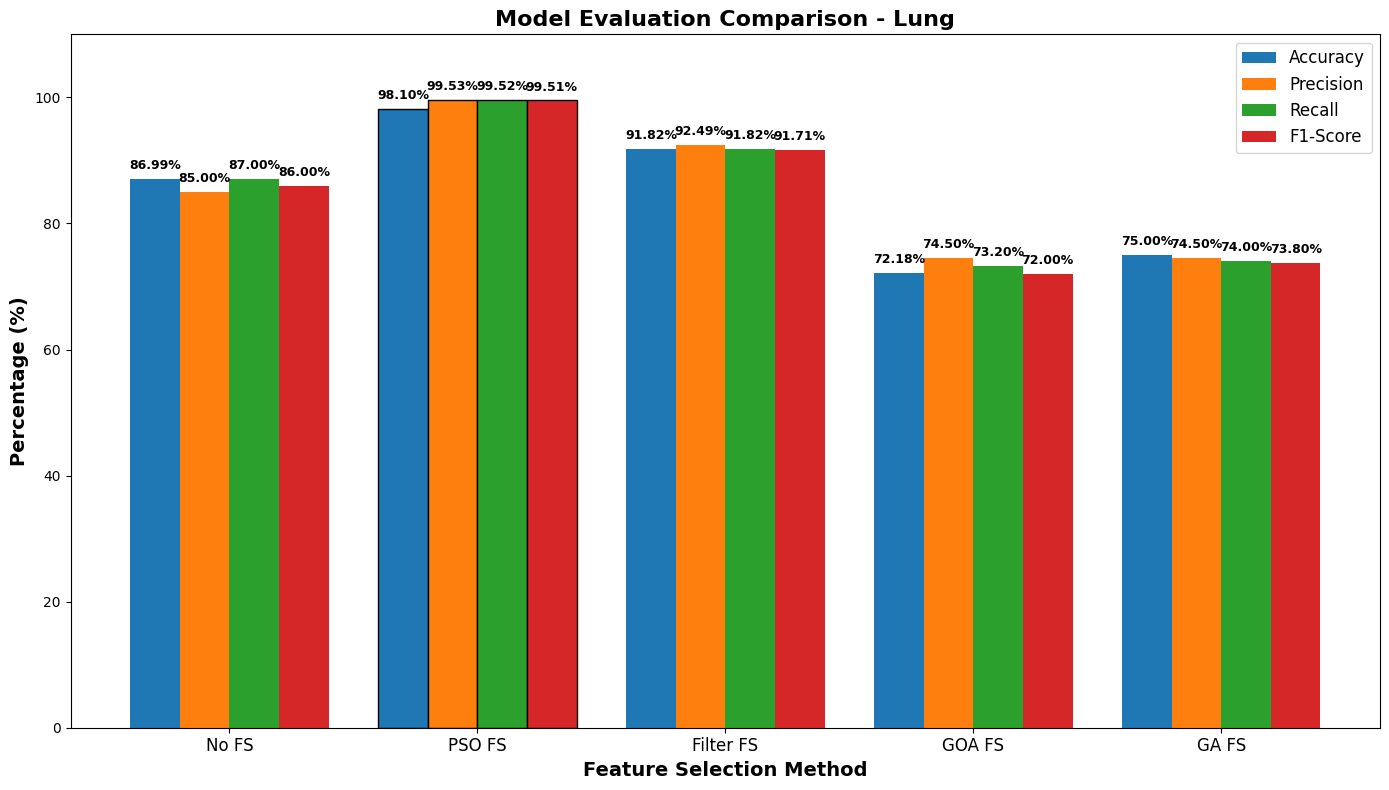

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ✅ Load the results
df = pd.read_csv('Lung_results.csv')

# ✅ Convert percentage strings to floats
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for col in metrics:
    df[col] = df[col].str.rstrip('%').astype(float)

# ✅ Plot grouped bar chart
x = np.arange(len(df['Feature Selection Method']))  # the label locations
width = 0.2  # width of each bar

# 📈 Increased figure size
fig, ax = plt.subplots(figsize=(14, 8))

# ✅ Identify PSO FS index to highlight its bars
pso_index = df[df['Feature Selection Method'] == 'PSO FS'].index[0]

# ✅ Create bars with black edge only for PSO FS
rects1 = ax.bar(x - 1.5*width, df['Accuracy'], width, label='Accuracy',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])
rects2 = ax.bar(x - 0.5*width, df['Precision'], width, label='Precision',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])
rects3 = ax.bar(x + 0.5*width, df['Recall'], width, label='Recall',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])
rects4 = ax.bar(x + 1.5*width, df['F1-Score'], width, label='F1-Score',
                edgecolor=['black' if i == pso_index else 'none' for i in range(len(df))])

# ✅ Annotate values on bars
for rect in [rects1, rects2, rects3, rects4]:
    for bar in rect:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# ✅ Labels and title (bold)
ax.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
ax.set_title('Model Evaluation Comparison - Lung', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Feature Selection Method'], fontsize=12)

# ✅ Legend
ax.legend(fontsize=12)
plt.ylim(0, 110)

plt.tight_layout()
plt.savefig("Lung_FS_Metrics_GroupedBar_PSO_Highlighted.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
!ls *.png

'Compare Evaluation_Metrics-Lung.png'
'Compare FR-Lung.png'
'Compare Number of FS-Lung.png'
'Compare Wrapper Evaluation-Lung.png'
'Compare Wrapper FS number-Lung.png'
'Feature Selection Trade-off: Features vs Accuracy (Lung).png'
 Lung_FS_Metrics_GroupedBar_PSO_Highlighted.png
 Lung_FS_Metrics_Heatmap.png


In [ ]:
!mkdir -p Lung_Plots #change based on the dataset


In [ ]:
!ls Lung_Plots

In [ ]:

lung_plots_path = '/content/drive/MyDrive/Lung_Plots'


In [ ]:
!mv *.csv Lung_Plots/

In [ ]:
!mv *.png Lung_Plots/

In [ ]:
!zip -r Lung_Plots.zip Lung_Plots


  adding: Lung_Plots/ (stored 0%)
  adding: Lung_Plots/Compare Wrapper Evaluation-Lung.png (deflated 17%)
  adding: Lung_Plots/Compare Evaluation_Metrics-Lung.png (deflated 18%)
  adding: Lung_Plots/Feature Selection Trade-off: Features vs Accuracy (Lung).png (deflated 17%)
  adding: Lung_Plots/Lung_FS_Metrics_GroupedBar_PSO_Highlighted.png (deflated 30%)
  adding: Lung_Plots/Lung_results.csv (deflated 34%)
  adding: Lung_Plots/Compare Number of FS-Lung.png (deflated 16%)
  adding: Lung_Plots/Compare FR-Lung.png (deflated 12%)
  adding: Lung_Plots/Compare Wrapper FS number-Lung.png (deflated 17%)
  adding: Lung_Plots/Lung_FS_Metrics_Heatmap.png (deflated 15%)


In [ ]:
from google.colab import files
files.download('Lung_Plots.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>